In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

print(tf.__version__)

2.8.0


In [2]:
path = '../../../project_data/data/fer_data.csv'
df = pd.read_csv(path)

# creating a dataframe that only contains training data
train = df[df['usage']=='train'].copy()
# dropping the usage column
train.drop(['usage'], axis = 1, inplace = True)
train.reset_index(inplace = True, drop = True)

# creating a dataframe that only contains training data
test = df[df['usage']=='test'].copy()
# dropping the usage column
test.drop(['usage'], axis = 1, inplace = True)
test.reset_index(inplace = True, drop = True)

# shuffling the test set
test = test.sample(frac=1).reset_index(drop=True)

In [3]:
# defininng validation set's length as a half of the original test set
valid_len = int(len(test)/2)
# and test as the remaining haflf
test_len = int(len(test) - valid_len)
print(valid_len,test_len)

3948 3948


In [4]:
valid = test.iloc[:valid_len,:]
valid.reset_index(inplace = True, drop=True)

test = test.iloc[test_len:,:]
test.reset_index(inplace = True, drop=True)

test.shape, valid.shape

((3948, 2), (3948, 2))

In [5]:
def get_pixels_and_scale(data):
    '''
    Function for extracting pixel values from the pixel column and scaling them between 0 and 1
    
    get values from the column|
    split on the whitespace
    convert to float16 datatype
    save as as numpy array
    scale the values between 0 and 1
    '''
    
    img_array = np.array(data.split(' '), dtype = 'float16')
    img_array = img_array / 255.0
    
    return img_array

def reshape_images(data):
    '''
    reshape pixels column into a (48,48,1)format
    return a numpy array
    '''

    reshaped_array = np.reshape(data['pixels'].to_list(),(data.shape[0],48,48,1))
    
    return reshaped_array

In [6]:
train['pixels'] = train['pixels'].apply(get_pixels_and_scale)
test['pixels'] = test['pixels'].apply(get_pixels_and_scale)
valid['pixels'] = valid['pixels'].apply(get_pixels_and_scale)

In [7]:
X_train = reshape_images(train)
y_train = train['emotion'].to_numpy()

X_test = reshape_images(test)
y_test = test['emotion'].to_numpy()

X_valid = reshape_images(valid)
y_valid = valid['emotion'].to_numpy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_valid.shape, y_valid.shape)

(31432, 48, 48, 1) (31432,)
(3948, 48, 48, 1) (3948,)
(3948, 48, 48, 1) (3948,)


In [ ]:
# np.savez('../../../project_data/train.npz', X_train=Xtrain, y_train=y_train)
# np.savez('../../../project_data/test.npz', X_test=X_test, y_test=y_test)
# np.savez('../../../project_data/validation.npz', X_valid=X_valid, y_valid=y_valid)

In [ ]:
# download_path = '../../../project_data/downloads/'

# !gdown 1Rjl3i86XTnDEKGUYT3Pjg8JfdBIdHt6y -O download_path # training set: train.npz
# !gdown 1e65FERfU4feXZ8FjB9q5JEhzPazjQXcn -O download_path # test set: test.npz
# !gdown 1f_Prjy7IChPW7FdZvWs0dsWh0DGBr43X -O download_path # validation set: validation.npz

In [ ]:
# test = np.load(download_path+'test.npz')
# # test.files
# test_images = test['test_images']
# test_labels = test['test_labels']

In [ ]:
# validation = np.load(download_path+'validation.npz')
# # validation.files
# validation_images = validation['arr_0']
# validation_labels = validation['arr_1']

In [8]:
def plot_model_accuracy(fitted_model):
    '''
    Function visualizing comparison of 
    training and validaton loss and accuracy
    
    '''
    
    fig , ax = plt.subplots(1,2)
    train_acc = fitted_model.history['accuracy']
    train_loss = fitted_model.history['loss']
    fig.set_size_inches(15,4)

    ax[0].plot(fitted_model.history['accuracy'])
    ax[0].plot(fitted_model.history['val_accuracy'])
    ax[0].set_title('Training vs Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Training', 'Validation'], loc='lower right')

    ax[1].plot(fitted_model.history['loss'])
    ax[1].plot(fitted_model.history['val_loss'])
    ax[1].set_title('Training vs Validation Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Training', 'Validation'], loc='lower left')

    plt.show()

In [13]:
# creating generators for image augmentation
train_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'   
)

train_gen.fit(X_train)
train_batch = 1024
train_gen = train_gen.flow(X_train, y_train, batch_size=train_batch)

valid_gen = ImageDataGenerator()
valid_batch = 128
valid_gen = valid_gen.flow(X_valid, y_valid, batch_size=valid_batch)

#checkpoint to save best weights
checkpoint_path = "../../../project_data/train_ckpt/cp_mdl_fin.ckpt"

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                monitor='val_accuracy',
                                                save_weights_only=True,
                                                mode='max',
                                                save_best_only=True,
                                                verbose=1)

# define number of epochs with no improvement after which training will be stopped
# validation accuracy
accuracy_monitor = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                          patience=100,
                          mode='max')

#loss
loss_monitor = tf.keras.callbacks.EarlyStopping(monitor='loss',
                          patience=100,
                          mode='min')

#define callbacks
callbacks = [accuracy_monitor, loss_monitor, checkpoint]

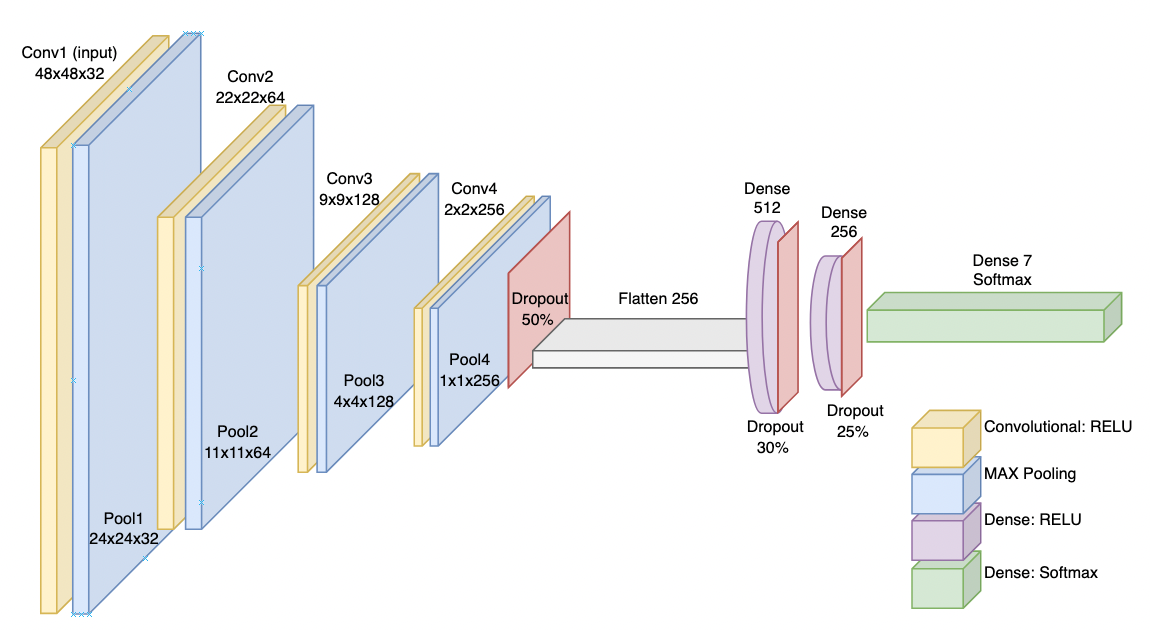

Epoch 1/1200


2022-05-22 01:23:28.896274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/30 [==============================] - ETA: 0s - loss: 2.4371 - accuracy: 0.2271

2022-05-22 01:23:40.058279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.22340, saving model to ../../../project_data/train_ckpt/cp_mdl_fin.ckpt
30/30 [==============================] - 12s 376ms/step - loss: 2.4371 - accuracy: 0.2271 - val_loss: 2.3276 - val_accuracy: 0.2234
Epoch 2/1200
31/30 [==============================] - ETA: 0s - loss: 2.0881 - accuracy: 0.2296
Epoch 2: val_accuracy improved from 0.22340 to 0.22594, saving model to ../../../project_data/train_ckpt/cp_mdl_fin.ckpt
30/30 [==============================] - 11s 365ms/step - loss: 2.0881 - accuracy: 0.2296 - val_loss: 2.0605 - val_accuracy: 0.2259
Epoch 3/1200
31/30 [==============================] - ETA: 0s - loss: 1.9836 - accuracy: 0.2306
Epoch 3: val_accuracy improved from 0.22594 to 0.22923, saving model to ../../../project_data/train_ckpt/cp_mdl_fin.ckpt
30/30 [==============================] - 11s 353ms/step - loss: 1.9836 - accuracy: 0.2306 - val_loss: 1.9321 - val_accuracy: 0.2292
Epoch 4/1200
31/30 [==============================]

Epoch 26/1200
31/30 [==============================] - ETA: 0s - loss: 1.6593 - accuracy: 0.3630
Epoch 26: val_accuracy did not improve from 0.42806
30/30 [==============================] - 15s 482ms/step - loss: 1.6593 - accuracy: 0.3630 - val_loss: 1.5623 - val_accuracy: 0.3972
Epoch 27/1200
31/30 [==============================] - ETA: 0s - loss: 1.6535 - accuracy: 0.3619
Epoch 27: val_accuracy did not improve from 0.42806
30/30 [==============================] - 15s 485ms/step - loss: 1.6535 - accuracy: 0.3619 - val_loss: 1.5273 - val_accuracy: 0.4233
Epoch 28/1200
31/30 [==============================] - ETA: 0s - loss: 1.6331 - accuracy: 0.3710
Epoch 28: val_accuracy improved from 0.42806 to 0.45137, saving model to ../../../project_data/train_ckpt/cp_mdl_fin.ckpt
30/30 [==============================] - 15s 482ms/step - loss: 1.6331 - accuracy: 0.3710 - val_loss: 1.4865 - val_accuracy: 0.4514
Epoch 29/1200
31/30 [==============================] - ETA: 0s - loss: 1.6200 - accurac

31/30 [==============================] - ETA: 0s - loss: 1.4426 - accuracy: 0.4575
Epoch 53: val_accuracy did not improve from 0.54331
30/30 [==============================] - 18s 566ms/step - loss: 1.4426 - accuracy: 0.4575 - val_loss: 1.3312 - val_accuracy: 0.5041
Epoch 54/1200
31/30 [==============================] - ETA: 0s - loss: 1.4301 - accuracy: 0.4626
Epoch 54: val_accuracy did not improve from 0.54331
30/30 [==============================] - 17s 565ms/step - loss: 1.4301 - accuracy: 0.4626 - val_loss: 1.2393 - val_accuracy: 0.5355
Epoch 55/1200
31/30 [==============================] - ETA: 0s - loss: 1.4276 - accuracy: 0.4653
Epoch 55: val_accuracy improved from 0.54331 to 0.54407, saving model to ../../../project_data/train_ckpt/cp_mdl_fin.ckpt
30/30 [==============================] - 18s 566ms/step - loss: 1.4276 - accuracy: 0.4653 - val_loss: 1.2531 - val_accuracy: 0.5441
Epoch 56/1200
31/30 [==============================] - ETA: 0s - loss: 1.4265 - accuracy: 0.4625
Epoc

30/30 [==============================] - 17s 558ms/step - loss: 1.3393 - accuracy: 0.5007 - val_loss: 1.1405 - val_accuracy: 0.5795
Epoch 81/1200
31/30 [==============================] - ETA: 0s - loss: 1.3295 - accuracy: 0.5035
Epoch 81: val_accuracy did not improve from 0.57953
30/30 [==============================] - 17s 548ms/step - loss: 1.3295 - accuracy: 0.5035 - val_loss: 1.1555 - val_accuracy: 0.5765
Epoch 82/1200
31/30 [==============================] - ETA: 0s - loss: 1.3287 - accuracy: 0.5048
Epoch 82: val_accuracy improved from 0.57953 to 0.58359, saving model to ../../../project_data/train_ckpt/cp_mdl_fin.ckpt
30/30 [==============================] - 17s 548ms/step - loss: 1.3287 - accuracy: 0.5048 - val_loss: 1.1582 - val_accuracy: 0.5836
Epoch 83/1200
31/30 [==============================] - ETA: 0s - loss: 1.3263 - accuracy: 0.5068
Epoch 83: val_accuracy did not improve from 0.58359
30/30 [==============================] - 17s 545ms/step - loss: 1.3263 - accuracy: 0.50

30/30 [==============================] - 309s 10s/step - loss: 1.2728 - accuracy: 0.5272 - val_loss: 1.1247 - val_accuracy: 0.5826
Epoch 109/1200
31/30 [==============================] - ETA: 0s - loss: 1.2690 - accuracy: 0.5285
Epoch 109: val_accuracy did not improve from 0.60841
30/30 [==============================] - 11s 359ms/step - loss: 1.2690 - accuracy: 0.5285 - val_loss: 1.0991 - val_accuracy: 0.5952
Epoch 110/1200
31/30 [==============================] - ETA: 0s - loss: 1.2589 - accuracy: 0.5353
Epoch 110: val_accuracy did not improve from 0.60841
30/30 [==============================] - 11s 357ms/step - loss: 1.2589 - accuracy: 0.5353 - val_loss: 1.1166 - val_accuracy: 0.5798
Epoch 111/1200
31/30 [==============================] - ETA: 0s - loss: 1.2626 - accuracy: 0.5304
Epoch 111: val_accuracy did not improve from 0.60841
30/30 [==============================] - 11s 357ms/step - loss: 1.2626 - accuracy: 0.5304 - val_loss: 1.0810 - val_accuracy: 0.5973
Epoch 112/1200
31/30

Epoch 137/1200
31/30 [==============================] - ETA: 0s - loss: 1.2222 - accuracy: 0.5477
Epoch 137: val_accuracy did not improve from 0.62513
30/30 [==============================] - 11s 350ms/step - loss: 1.2222 - accuracy: 0.5477 - val_loss: 1.0405 - val_accuracy: 0.6130
Epoch 138/1200
31/30 [==============================] - ETA: 0s - loss: 1.2107 - accuracy: 0.5518
Epoch 138: val_accuracy did not improve from 0.62513
30/30 [==============================] - 11s 353ms/step - loss: 1.2107 - accuracy: 0.5518 - val_loss: 1.0196 - val_accuracy: 0.6173
Epoch 139/1200
31/30 [==============================] - ETA: -3s - loss: 1.2205 - accuracy: 0.5496
Epoch 139: val_accuracy did not improve from 0.62513
30/30 [==============================] - 311s 10s/step - loss: 1.2205 - accuracy: 0.5496 - val_loss: 1.0486 - val_accuracy: 0.6097
Epoch 140/1200
31/30 [==============================] - ETA: 0s - loss: 1.2175 - accuracy: 0.5485
Epoch 140: val_accuracy did not improve from 0.62513


30/30 [==============================] - 11s 361ms/step - loss: 1.1884 - accuracy: 0.5602 - val_loss: 1.0081 - val_accuracy: 0.6264
Epoch 166/1200
31/30 [==============================] - ETA: 0s - loss: 1.1875 - accuracy: 0.5634
Epoch 166: val_accuracy did not improve from 0.63703
30/30 [==============================] - 11s 352ms/step - loss: 1.1875 - accuracy: 0.5634 - val_loss: 1.0131 - val_accuracy: 0.6292
Epoch 167/1200
31/30 [==============================] - ETA: -3s - loss: 1.1822 - accuracy: 0.5628
Epoch 167: val_accuracy did not improve from 0.63703
30/30 [==============================] - 309s 10s/step - loss: 1.1822 - accuracy: 0.5628 - val_loss: 0.9927 - val_accuracy: 0.6363
Epoch 168/1200
31/30 [==============================] - ETA: 0s - loss: 1.1797 - accuracy: 0.5627
Epoch 168: val_accuracy did not improve from 0.63703
30/30 [==============================] - 11s 360ms/step - loss: 1.1797 - accuracy: 0.5627 - val_loss: 1.0252 - val_accuracy: 0.6150
Epoch 169/1200
31/3

Epoch 194/1200
31/30 [==============================] - ETA: 0s - loss: 1.1523 - accuracy: 0.5730
Epoch 194: val_accuracy did not improve from 0.63982
30/30 [==============================] - 11s 368ms/step - loss: 1.1523 - accuracy: 0.5730 - val_loss: 0.9880 - val_accuracy: 0.6375
Epoch 195/1200
31/30 [==============================] - ETA: 0s - loss: 1.1532 - accuracy: 0.5721
Epoch 195: val_accuracy did not improve from 0.63982
30/30 [==============================] - 11s 349ms/step - loss: 1.1532 - accuracy: 0.5721 - val_loss: 0.9999 - val_accuracy: 0.6246
Epoch 196/1200
31/30 [==============================] - ETA: 0s - loss: 1.1566 - accuracy: 0.5714
Epoch 196: val_accuracy did not improve from 0.63982
30/30 [==============================] - 11s 349ms/step - loss: 1.1566 - accuracy: 0.5714 - val_loss: 1.0134 - val_accuracy: 0.6299
Epoch 197/1200
31/30 [==============================] - ETA: -3s - loss: 1.1500 - accuracy: 0.5726
Epoch 197: val_accuracy did not improve from 0.63982

30/30 [==============================] - 11s 349ms/step - loss: 1.1323 - accuracy: 0.5804 - val_loss: 1.0210 - val_accuracy: 0.6216
Epoch 223/1200
31/30 [==============================] - ETA: 0s - loss: 1.1280 - accuracy: 0.5833
Epoch 223: val_accuracy improved from 0.64311 to 0.64564, saving model to ../../../project_data/train_ckpt/cp_mdl_fin.ckpt
30/30 [==============================] - 11s 363ms/step - loss: 1.1280 - accuracy: 0.5833 - val_loss: 0.9614 - val_accuracy: 0.6456
Epoch 224/1200
31/30 [==============================] - ETA: 0s - loss: 1.1312 - accuracy: 0.5821
Epoch 224: val_accuracy did not improve from 0.64564
30/30 [==============================] - 11s 350ms/step - loss: 1.1312 - accuracy: 0.5821 - val_loss: 0.9705 - val_accuracy: 0.6408
Epoch 225/1200
31/30 [==============================] - ETA: 0s - loss: 1.1223 - accuracy: 0.5845
Epoch 225: val_accuracy did not improve from 0.64564
30/30 [==============================] - 11s 349ms/step - loss: 1.1223 - accuracy

Epoch 251/1200
31/30 [==============================] - ETA: 0s - loss: 1.1182 - accuracy: 0.5879
Epoch 251: val_accuracy did not improve from 0.64716
30/30 [==============================] - 11s 357ms/step - loss: 1.1182 - accuracy: 0.5879 - val_loss: 0.9691 - val_accuracy: 0.6380
Epoch 252/1200
31/30 [==============================] - ETA: 0s - loss: 1.1144 - accuracy: 0.5879
Epoch 252: val_accuracy did not improve from 0.64716
30/30 [==============================] - 11s 368ms/step - loss: 1.1144 - accuracy: 0.5879 - val_loss: 0.9755 - val_accuracy: 0.6353
Epoch 253/1200
31/30 [==============================] - ETA: 0s - loss: 1.1110 - accuracy: 0.5881
Epoch 253: val_accuracy did not improve from 0.64716
30/30 [==============================] - 11s 358ms/step - loss: 1.1110 - accuracy: 0.5881 - val_loss: 0.9620 - val_accuracy: 0.6454
Epoch 254/1200
31/30 [==============================] - ETA: 0s - loss: 1.1108 - accuracy: 0.5908
Epoch 254: val_accuracy did not improve from 0.64716


30/30 [==============================] - 11s 349ms/step - loss: 1.0950 - accuracy: 0.5985 - val_loss: 0.9698 - val_accuracy: 0.6439
Epoch 280/1200
31/30 [==============================] - ETA: -9s - loss: 1.0917 - accuracy: 0.5966
Epoch 280: val_accuracy did not improve from 0.65198
30/30 [==============================] - 938s 32s/step - loss: 1.0917 - accuracy: 0.5966 - val_loss: 0.9638 - val_accuracy: 0.6484
Epoch 281/1200
31/30 [==============================] - ETA: 0s - loss: 1.0954 - accuracy: 0.5962
Epoch 281: val_accuracy did not improve from 0.65198
30/30 [==============================] - 12s 378ms/step - loss: 1.0954 - accuracy: 0.5962 - val_loss: 0.9575 - val_accuracy: 0.6474
Epoch 282/1200
31/30 [==============================] - ETA: 0s - loss: 1.0959 - accuracy: 0.5954
Epoch 282: val_accuracy did not improve from 0.65198
30/30 [==============================] - 11s 355ms/step - loss: 1.0959 - accuracy: 0.5954 - val_loss: 0.9611 - val_accuracy: 0.6459
Epoch 283/1200
31/3

Epoch 308/1200
31/30 [==============================] - ETA: -3s - loss: 1.0744 - accuracy: 0.6025
Epoch 308: val_accuracy did not improve from 0.65628
30/30 [==============================] - 310s 10s/step - loss: 1.0744 - accuracy: 0.6025 - val_loss: 0.9604 - val_accuracy: 0.6461
Epoch 309/1200
31/30 [==============================] - ETA: 0s - loss: 1.0754 - accuracy: 0.6071
Epoch 309: val_accuracy did not improve from 0.65628
30/30 [==============================] - 11s 358ms/step - loss: 1.0754 - accuracy: 0.6071 - val_loss: 0.9457 - val_accuracy: 0.6540
Epoch 310/1200
31/30 [==============================] - ETA: 0s - loss: 1.0870 - accuracy: 0.6008
Epoch 310: val_accuracy did not improve from 0.65628
30/30 [==============================] - 11s 351ms/step - loss: 1.0870 - accuracy: 0.6008 - val_loss: 0.9766 - val_accuracy: 0.6429
Epoch 311/1200
31/30 [==============================] - ETA: 0s - loss: 1.0761 - accuracy: 0.6025
Epoch 311: val_accuracy did not improve from 0.65628


Epoch 337/1200
31/30 [==============================] - ETA: 0s - loss: 1.0668 - accuracy: 0.6035
Epoch 337: val_accuracy improved from 0.65755 to 0.65932, saving model to ../../../project_data/train_ckpt/cp_mdl_fin.ckpt
30/30 [==============================] - 11s 357ms/step - loss: 1.0668 - accuracy: 0.6035 - val_loss: 0.9419 - val_accuracy: 0.6593
Epoch 338/1200
31/30 [==============================] - ETA: 0s - loss: 1.0688 - accuracy: 0.6079
Epoch 338: val_accuracy did not improve from 0.65932
30/30 [==============================] - 11s 360ms/step - loss: 1.0688 - accuracy: 0.6079 - val_loss: 0.9795 - val_accuracy: 0.6375
Epoch 339/1200
31/30 [==============================] - ETA: 0s - loss: 1.0665 - accuracy: 0.6054
Epoch 339: val_accuracy did not improve from 0.65932
30/30 [==============================] - 11s 356ms/step - loss: 1.0665 - accuracy: 0.6054 - val_loss: 0.9527 - val_accuracy: 0.6510
Epoch 340/1200
31/30 [==============================] - ETA: 0s - loss: 1.0707 - 

30/30 [==============================] - 11s 356ms/step - loss: 1.0605 - accuracy: 0.6092 - val_loss: 0.9361 - val_accuracy: 0.6570
Epoch 366/1200
31/30 [==============================] - ETA: 0s - loss: 1.0529 - accuracy: 0.6109
Epoch 366: val_accuracy did not improve from 0.66059
30/30 [==============================] - 11s 355ms/step - loss: 1.0529 - accuracy: 0.6109 - val_loss: 0.9778 - val_accuracy: 0.6434
Epoch 367/1200
31/30 [==============================] - ETA: 0s - loss: 1.0493 - accuracy: 0.6114
Epoch 367: val_accuracy did not improve from 0.66059
30/30 [==============================] - 11s 353ms/step - loss: 1.0493 - accuracy: 0.6114 - val_loss: 0.9458 - val_accuracy: 0.6545
Epoch 368/1200
31/30 [==============================] - ETA: 0s - loss: 1.0580 - accuracy: 0.6093
Epoch 368: val_accuracy did not improve from 0.66059
30/30 [==============================] - 11s 354ms/step - loss: 1.0580 - accuracy: 0.6093 - val_loss: 0.9532 - val_accuracy: 0.6446
Epoch 369/1200
31/3

Epoch 394/1200
31/30 [==============================] - ETA: 0s - loss: 1.0499 - accuracy: 0.6127
Epoch 394: val_accuracy did not improve from 0.67275
30/30 [==============================] - 11s 357ms/step - loss: 1.0499 - accuracy: 0.6127 - val_loss: 0.9389 - val_accuracy: 0.6507
Epoch 395/1200
31/30 [==============================] - ETA: 0s - loss: 1.0481 - accuracy: 0.6160
Epoch 395: val_accuracy did not improve from 0.67275
30/30 [==============================] - 12s 389ms/step - loss: 1.0481 - accuracy: 0.6160 - val_loss: 0.9196 - val_accuracy: 0.6659
Epoch 396/1200
31/30 [==============================] - ETA: 0s - loss: 1.0564 - accuracy: 0.6082
Epoch 396: val_accuracy did not improve from 0.67275
30/30 [==============================] - 12s 374ms/step - loss: 1.0564 - accuracy: 0.6082 - val_loss: 0.9429 - val_accuracy: 0.6497
Epoch 397/1200
31/30 [==============================] - ETA: 0s - loss: 1.0474 - accuracy: 0.6120
Epoch 397: val_accuracy did not improve from 0.67275


Epoch 423/1200
31/30 [==============================] - ETA: 0s - loss: 1.0453 - accuracy: 0.6128
Epoch 423: val_accuracy did not improve from 0.67275
30/30 [==============================] - 13s 435ms/step - loss: 1.0453 - accuracy: 0.6128 - val_loss: 0.9521 - val_accuracy: 0.6532
Epoch 424/1200
31/30 [==============================] - ETA: 0s - loss: 1.0371 - accuracy: 0.6181
Epoch 424: val_accuracy did not improve from 0.67275
30/30 [==============================] - 14s 447ms/step - loss: 1.0371 - accuracy: 0.6181 - val_loss: 0.9107 - val_accuracy: 0.6657
Epoch 425/1200
31/30 [==============================] - ETA: 0s - loss: 1.0294 - accuracy: 0.6219
Epoch 425: val_accuracy did not improve from 0.67275
30/30 [==============================] - 14s 455ms/step - loss: 1.0294 - accuracy: 0.6219 - val_loss: 0.9157 - val_accuracy: 0.6664
Epoch 426/1200
31/30 [==============================] - ETA: 0s - loss: 1.0348 - accuracy: 0.6170
Epoch 426: val_accuracy did not improve from 0.67275


Epoch 452/1200
31/30 [==============================] - ETA: 0s - loss: 1.0328 - accuracy: 0.6171
Epoch 452: val_accuracy did not improve from 0.67275
30/30 [==============================] - 16s 508ms/step - loss: 1.0328 - accuracy: 0.6171 - val_loss: 0.9171 - val_accuracy: 0.6664
Epoch 453/1200
31/30 [==============================] - ETA: 0s - loss: 1.0337 - accuracy: 0.6188
Epoch 453: val_accuracy did not improve from 0.67275
30/30 [==============================] - 15s 501ms/step - loss: 1.0337 - accuracy: 0.6188 - val_loss: 0.9233 - val_accuracy: 0.6684
Epoch 454/1200
31/30 [==============================] - ETA: 0s - loss: 1.0426 - accuracy: 0.6155
Epoch 454: val_accuracy improved from 0.67275 to 0.67452, saving model to ../../../project_data/train_ckpt/cp_mdl_fin.ckpt
30/30 [==============================] - 16s 506ms/step - loss: 1.0426 - accuracy: 0.6155 - val_loss: 0.9035 - val_accuracy: 0.6745
Epoch 455/1200
31/30 [==============================] - ETA: 0s - loss: 1.0316 - 

Epoch 481/1200
31/30 [==============================] - ETA: 0s - loss: 1.0288 - accuracy: 0.6236
Epoch 481: val_accuracy did not improve from 0.67452
30/30 [==============================] - 16s 531ms/step - loss: 1.0288 - accuracy: 0.6236 - val_loss: 0.9147 - val_accuracy: 0.6629
Epoch 482/1200
31/30 [==============================] - ETA: 0s - loss: 1.0269 - accuracy: 0.6202
Epoch 482: val_accuracy did not improve from 0.67452
30/30 [==============================] - 17s 538ms/step - loss: 1.0269 - accuracy: 0.6202 - val_loss: 0.9131 - val_accuracy: 0.6669
Epoch 483/1200
31/30 [==============================] - ETA: 0s - loss: 1.0185 - accuracy: 0.6262
Epoch 483: val_accuracy did not improve from 0.67452
30/30 [==============================] - 17s 538ms/step - loss: 1.0185 - accuracy: 0.6262 - val_loss: 0.9250 - val_accuracy: 0.6621
Epoch 484/1200
31/30 [==============================] - ETA: 0s - loss: 1.0303 - accuracy: 0.6197
Epoch 484: val_accuracy did not improve from 0.67452


Epoch 510/1200
31/30 [==============================] - ETA: 0s - loss: 1.0198 - accuracy: 0.6250
Epoch 510: val_accuracy did not improve from 0.67452
30/30 [==============================] - 17s 552ms/step - loss: 1.0198 - accuracy: 0.6250 - val_loss: 0.9145 - val_accuracy: 0.6629
Epoch 511/1200
31/30 [==============================] - ETA: 0s - loss: 1.0196 - accuracy: 0.6235
Epoch 511: val_accuracy did not improve from 0.67452
30/30 [==============================] - 17s 562ms/step - loss: 1.0196 - accuracy: 0.6235 - val_loss: 0.9337 - val_accuracy: 0.6581
Epoch 512/1200
31/30 [==============================] - ETA: 0s - loss: 1.0152 - accuracy: 0.6265
Epoch 512: val_accuracy did not improve from 0.67452
30/30 [==============================] - 17s 559ms/step - loss: 1.0152 - accuracy: 0.6265 - val_loss: 0.9274 - val_accuracy: 0.6596
Epoch 513/1200
31/30 [==============================] - ETA: 0s - loss: 1.0112 - accuracy: 0.6262
Epoch 513: val_accuracy did not improve from 0.67452


Epoch 539/1200
31/30 [==============================] - ETA: 0s - loss: 1.0141 - accuracy: 0.6265
Epoch 539: val_accuracy did not improve from 0.67452
30/30 [==============================] - 17s 565ms/step - loss: 1.0141 - accuracy: 0.6265 - val_loss: 0.9330 - val_accuracy: 0.6659
Epoch 540/1200
31/30 [==============================] - ETA: 0s - loss: 1.0110 - accuracy: 0.6273
Epoch 540: val_accuracy did not improve from 0.67452
30/30 [==============================] - 17s 563ms/step - loss: 1.0110 - accuracy: 0.6273 - val_loss: 0.9059 - val_accuracy: 0.6669
Epoch 541/1200
31/30 [==============================] - ETA: 0s - loss: 1.0101 - accuracy: 0.6260
Epoch 541: val_accuracy did not improve from 0.67452
30/30 [==============================] - 18s 567ms/step - loss: 1.0101 - accuracy: 0.6260 - val_loss: 0.9091 - val_accuracy: 0.6687
Epoch 542/1200
31/30 [==============================] - ETA: 0s - loss: 1.0054 - accuracy: 0.6313
Epoch 542: val_accuracy did not improve from 0.67452


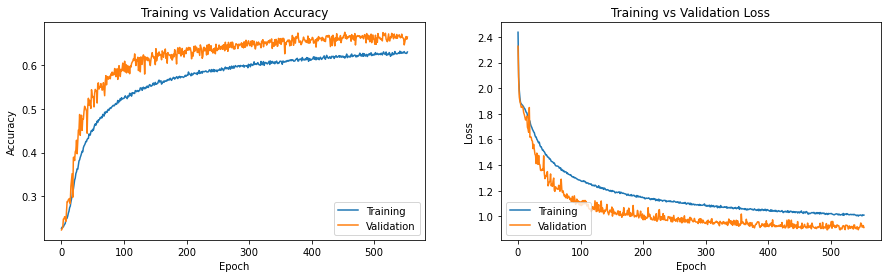

Evaluate on test data


2022-05-22 08:46:25.322539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 20ms/step - loss: 0.9260 - accuracy: 0.6707
test_loss, test_acc:  0.926 67.0719


In [14]:
mdl = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,
                           (3,3), 
                           activation='relu', 
                           input_shape=(48, 48, 1),
                           padding='same',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu',
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(7, activation='softmax',
                          activity_regularizer=regularizers.L2(1e-3))
])

mdl.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0005),
              metrics=['accuracy'])

history = mdl.fit(
      train_gen,
      validation_data = valid_gen,  
      epochs = 1200,
      steps_per_epoch=len(X_train)/train_batch,
      validation_steps=len(X_valid)/valid_batch,
      verbose=1,
      callbacks=[callbacks])

plot_model_accuracy(history)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss, test_acc = mdl.evaluate(X_test, y_test, batch_size=128)
print('test_loss, test_acc: ',np.round(test_loss,4), np.round(test_acc*100.0,4))

In [35]:
# exporting the model
mdl.save('../../../project_data/mdl_fin.h5')

# exporting model history
np.save('../../../project_data/history_fin.npy',history.history)

In [36]:
# # Visualizing history from a loaded file

# # loading history from export
# history_loaded=np.load('../../../project_data/history_fin.npy',allow_pickle='TRUE').item()

# fig , ax = plt.subplots(1,2)
# train_acc = history_loaded['accuracy']
# train_loss = history_loaded['loss']
# fig.set_size_inches(15,4)

# ax[0].plot(history_loaded['accuracy'])
# ax[0].plot(history_loaded['val_accuracy'])
# ax[0].set_title('Training vs Validation Accuracy')
# ax[0].set_ylabel('Accuracy')
# ax[0].set_xlabel('Epoch')
# ax[0].legend(['Training', 'Validation'], loc='lower right')

# ax[1].plot(history_loaded['loss'])
# ax[1].plot(history_loaded['val_loss'])
# ax[1].set_title('Training vs Validation Loss')
# ax[1].set_ylabel('Loss')
# ax[1].set_xlabel('Epoch')
# ax[1].legend(['Training', 'Validation'], loc='lower left')

# plt.show()

## Performance Evaluation

In [ ]:
# loading parameters of the best pre-trained model
# download_path = '../../../project_data/downloads/'
# !gdown '171QgNKyPJ01kbP2txmwKPLI7UMfw0NFO' -O mdl_best.h5

In [56]:
# creating a model from pre-trained file
loaded_model = tf.keras.models.load_model('/models/tf_cnn_mdl16_4.h5')

OSError: No file or directory found at /models/tf_cnn_mdl16_4.h5

In [39]:
# predicting the labels for test images
y_pred = loaded_model.predict(X_test)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss, test_acc = loaded_model.evaluate(X_test, y_test, batch_size=128)
print('test_loss, test_acc: ',np.round(test_loss,4), np.round(test_acc*100.0,4))

2022-05-22 11:48:51.519880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Evaluate on test data
 1/31 [..............................] - ETA: 6s - loss: 0.7692 - accuracy: 0.7422

2022-05-22 11:48:52.637794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 23ms/step - loss: 0.8849 - accuracy: 0.6771
test_loss, test_acc:  0.8849 67.7052


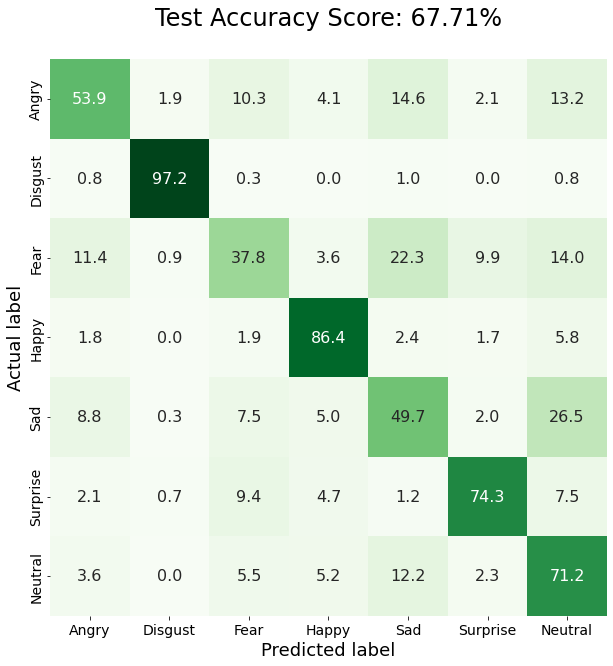

In [41]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# dictionary to decode labels
emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

# confusion matrix with actual label names
cm_labels = confusion_matrix(y_test, y_pred.argmax(axis=1))
# normalizing the values
cm_labels_norm = cm_labels.astype('float') / cm_labels.sum(axis=1)[:, np.newaxis]
cm_labels_norm = cm_labels_norm * 100.00

plt.figure(figsize=(9,9))
sns.heatmap(cm_labels_norm,
            annot=True, 
            annot_kws={'size':16},
            fmt=".1f",
           cmap='Greens',
           xticklabels=[i for i in emotions.values()],
           yticklabels=[i for i in emotions.values()],
           square=True,
           cbar=False)
plt.title('Test Accuracy Score: {0}%\n'.format("%.2f" % (test_acc*100.0)), size=24)
plt.tight_layout()
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylabel('Actual label', size=18)
plt.xlabel('Predicted label', size=18)
plt.show()

## Activation Maps

In [42]:
from keract import get_activations
from keract import display_activations

In [43]:
# function to expand dimensions of a given image to match the model input shape
def expand_img_dims(img_array):
    import numpy as np
    return np.expand_dims(img_array, axis=0)

2535
conv2d_4_input (1, 48, 48, 1) 


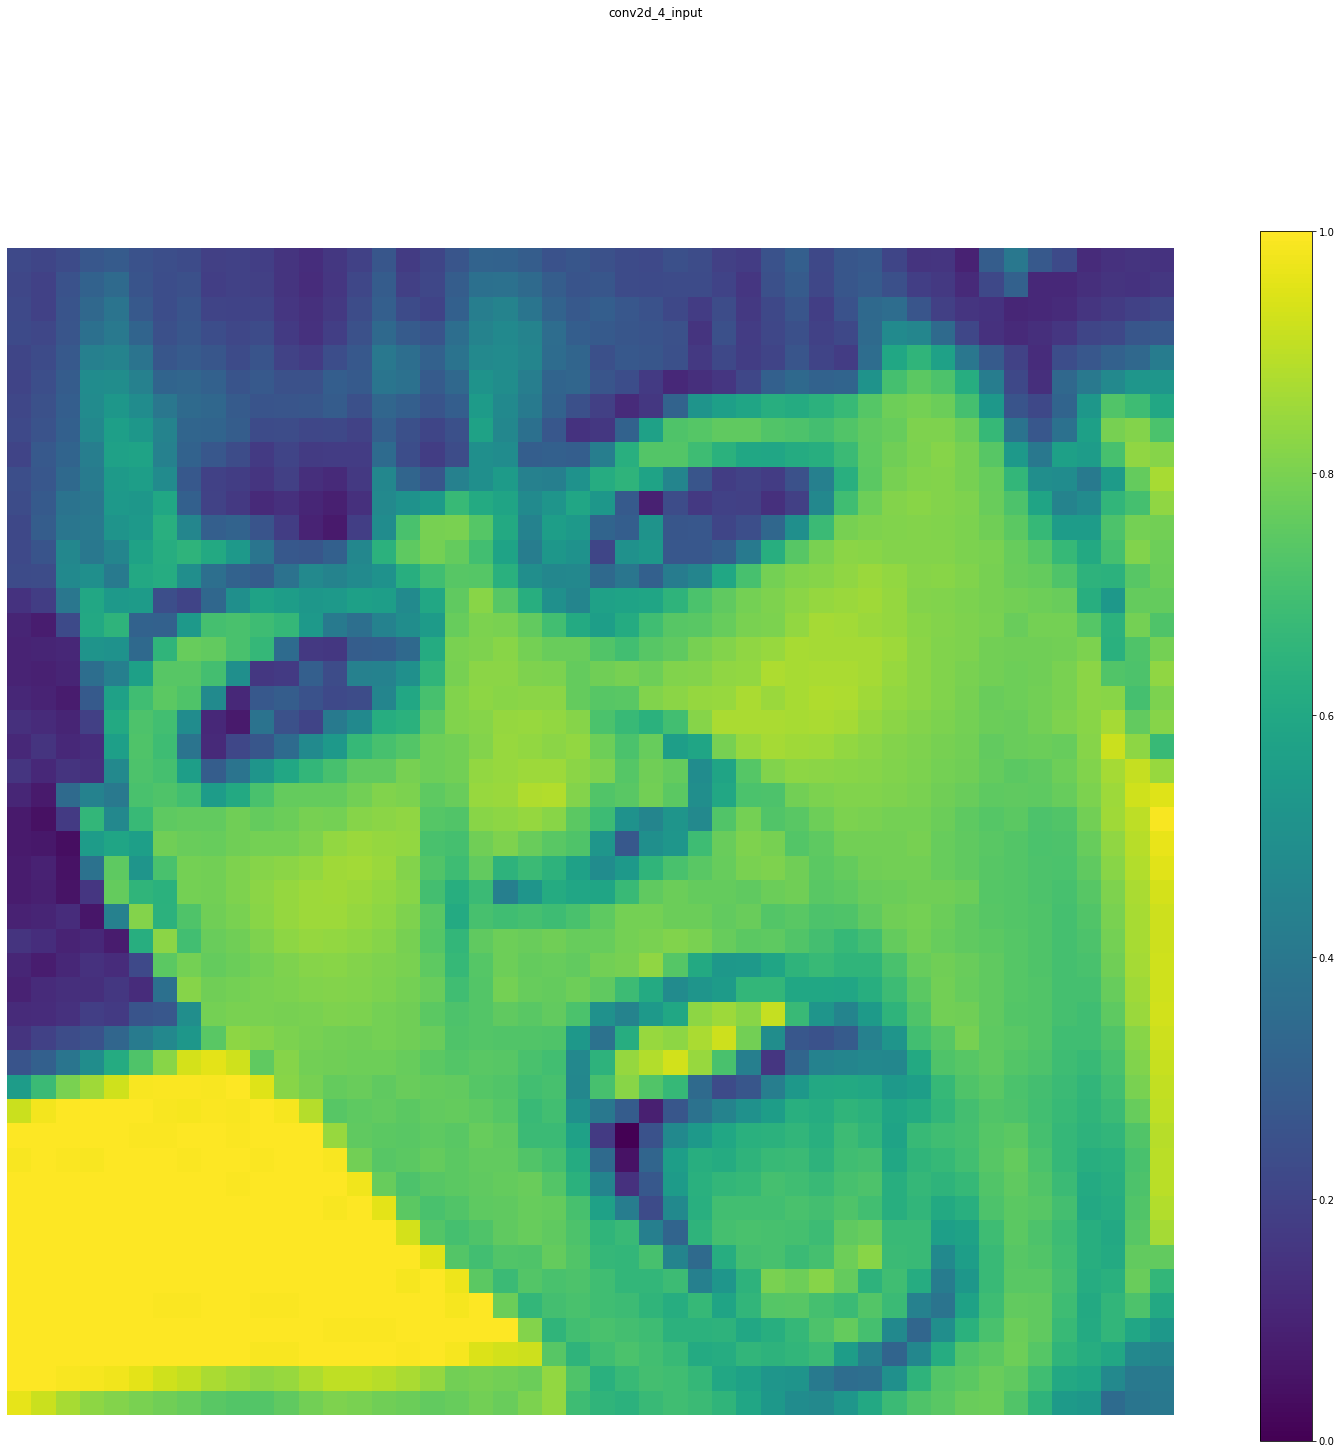

conv2d_4 (1, 48, 48, 32) 


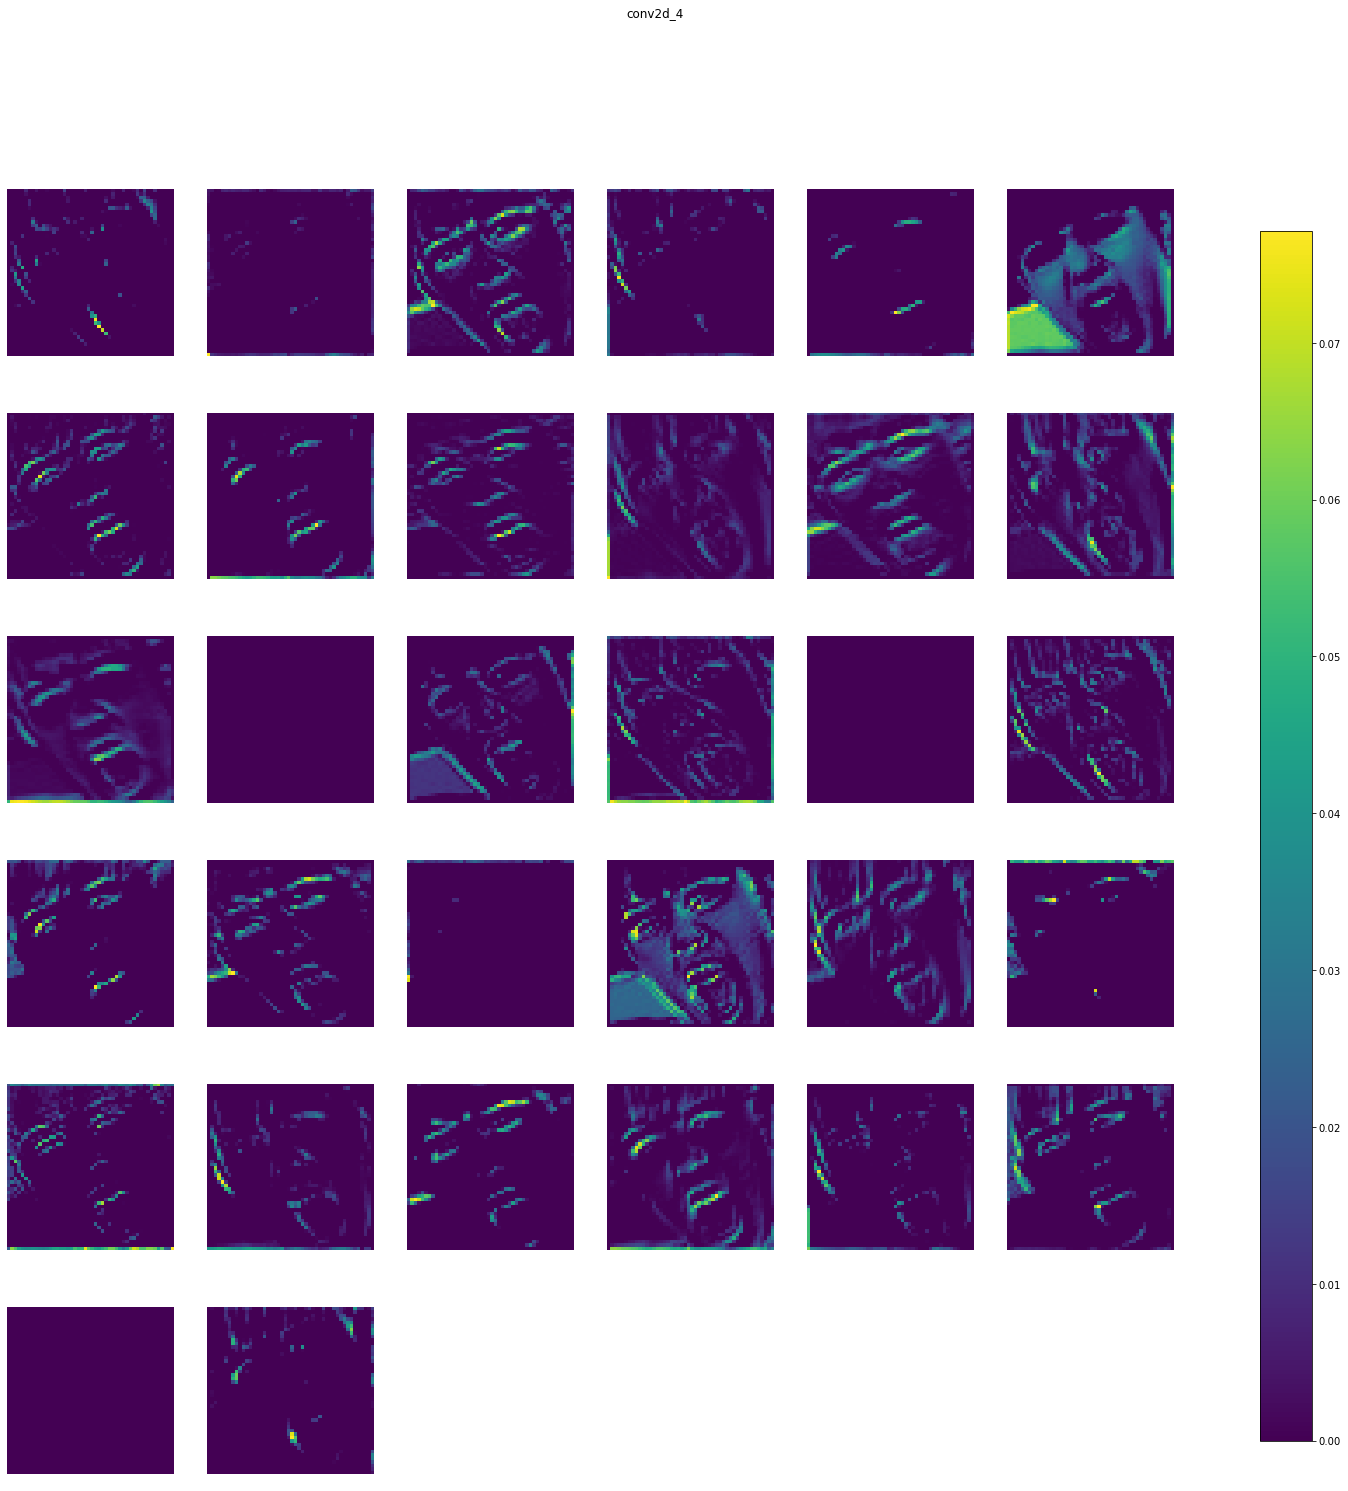

max_pooling2d_4 (1, 24, 24, 32) 


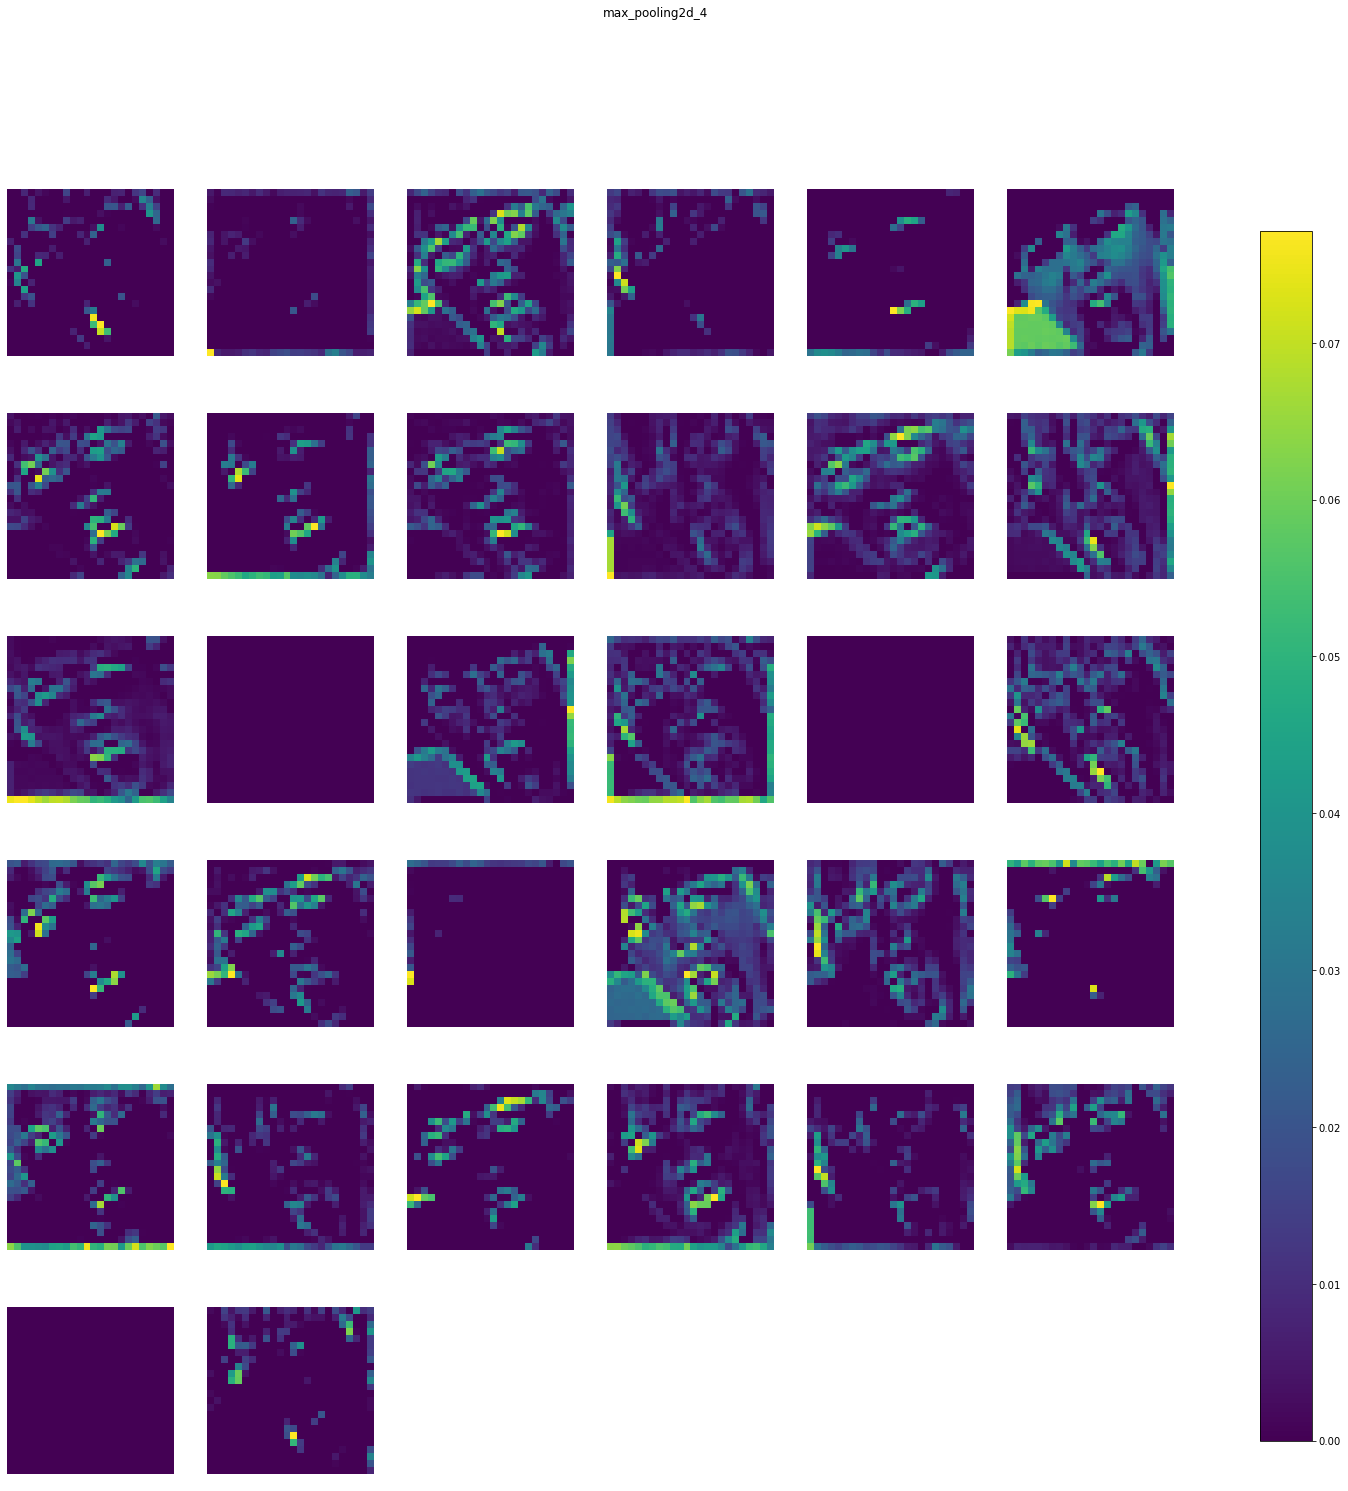

conv2d_5 (1, 22, 22, 64) 


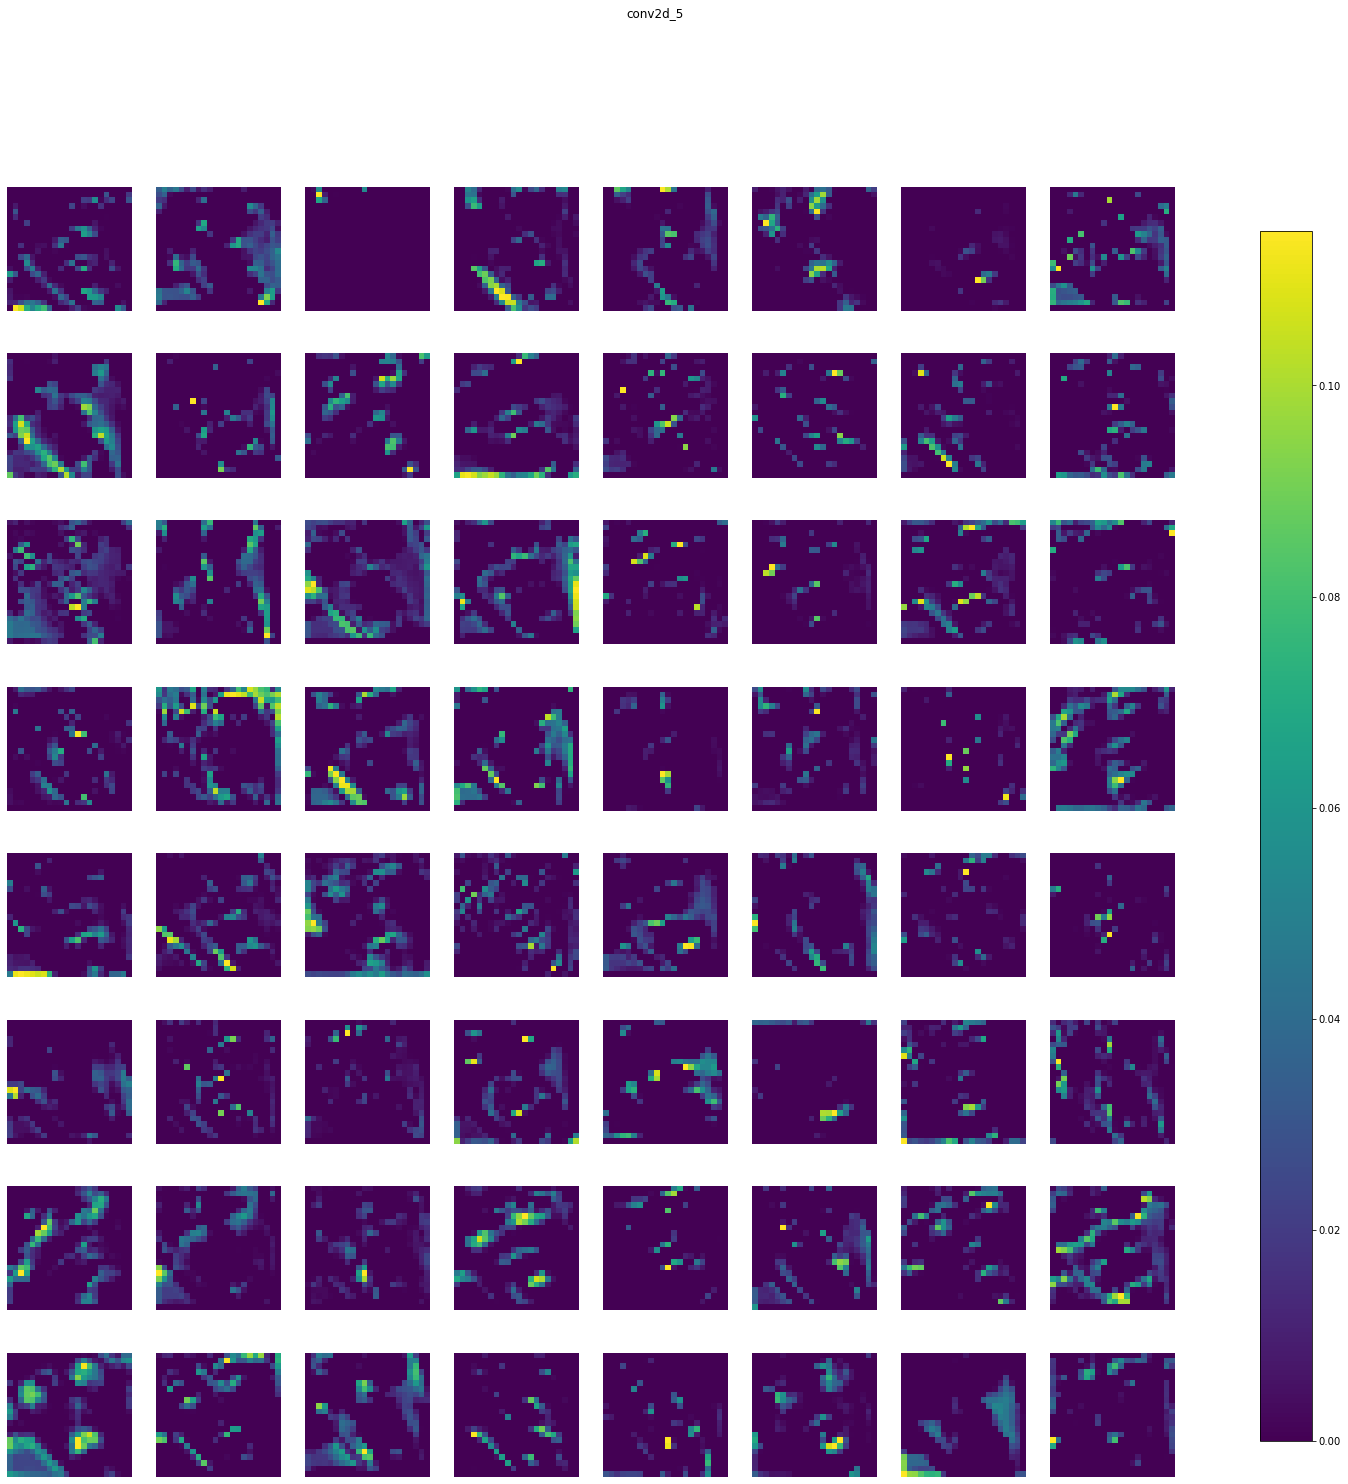

max_pooling2d_5 (1, 11, 11, 64) 


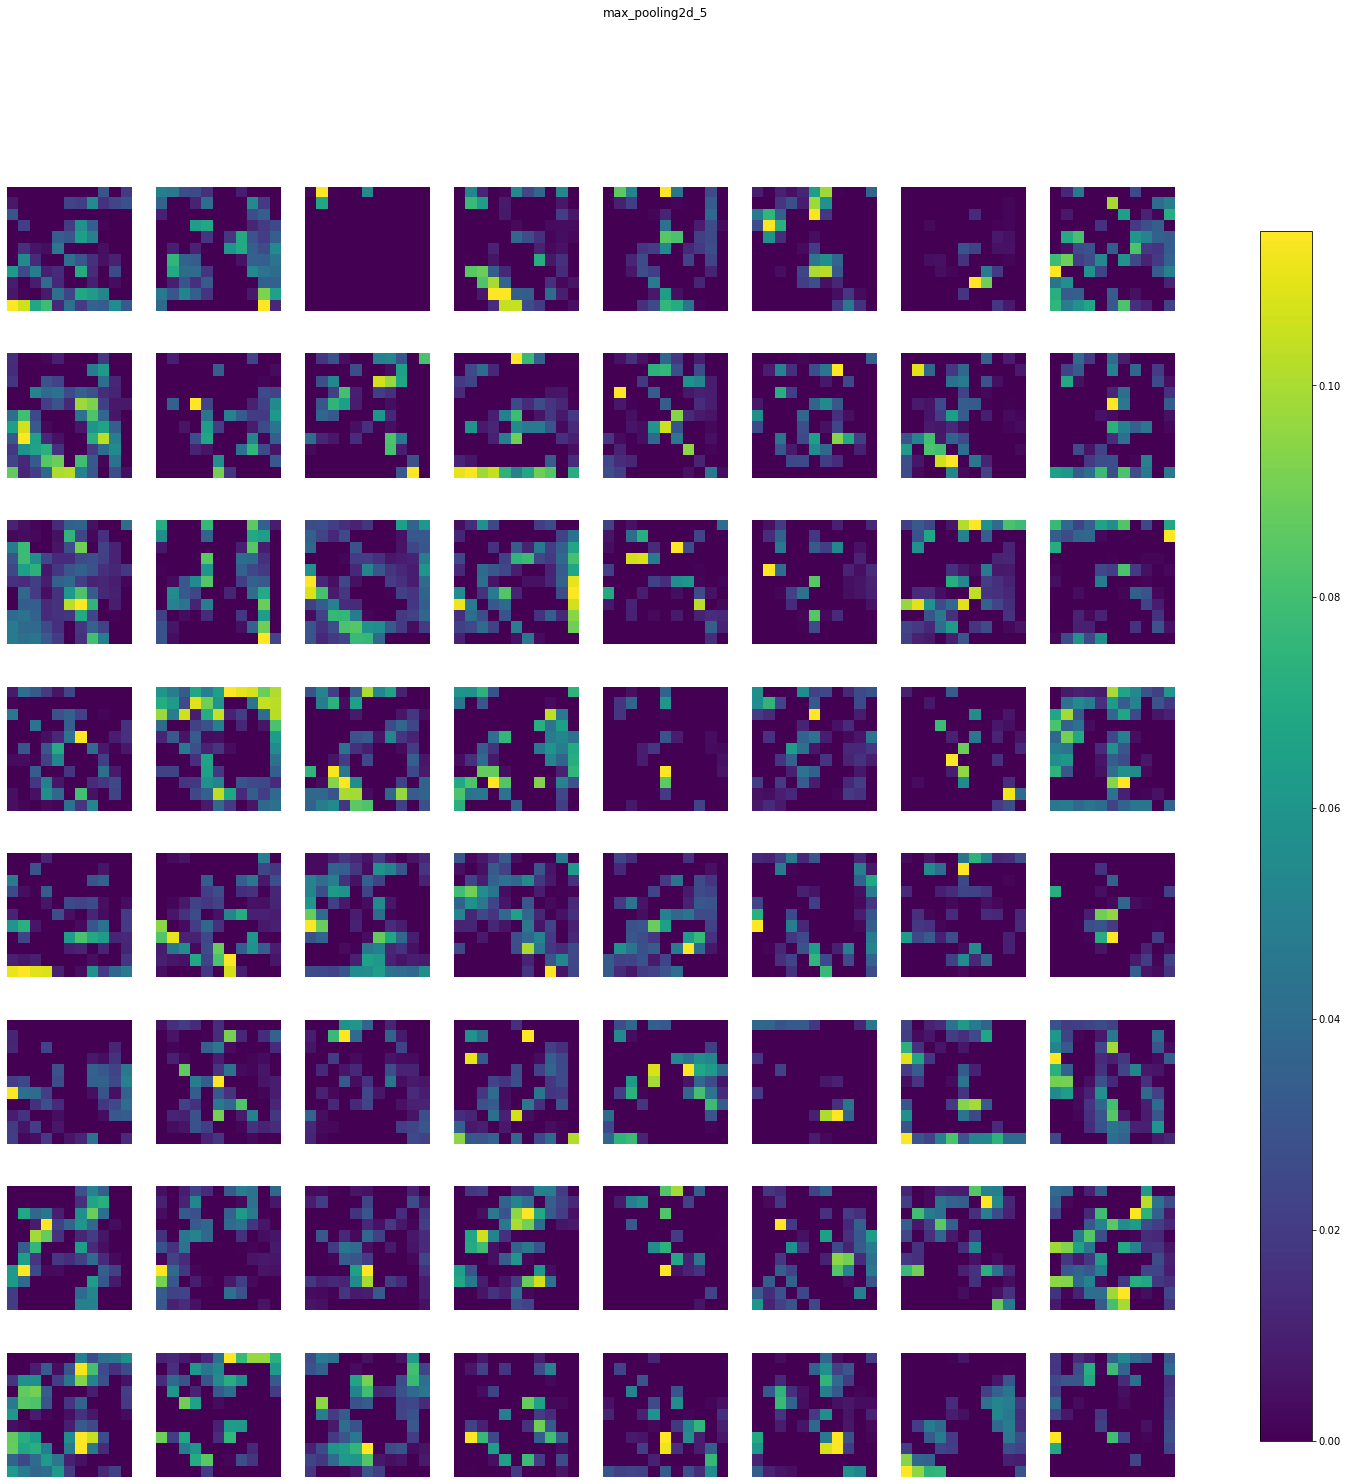

conv2d_6 (1, 9, 9, 128) 


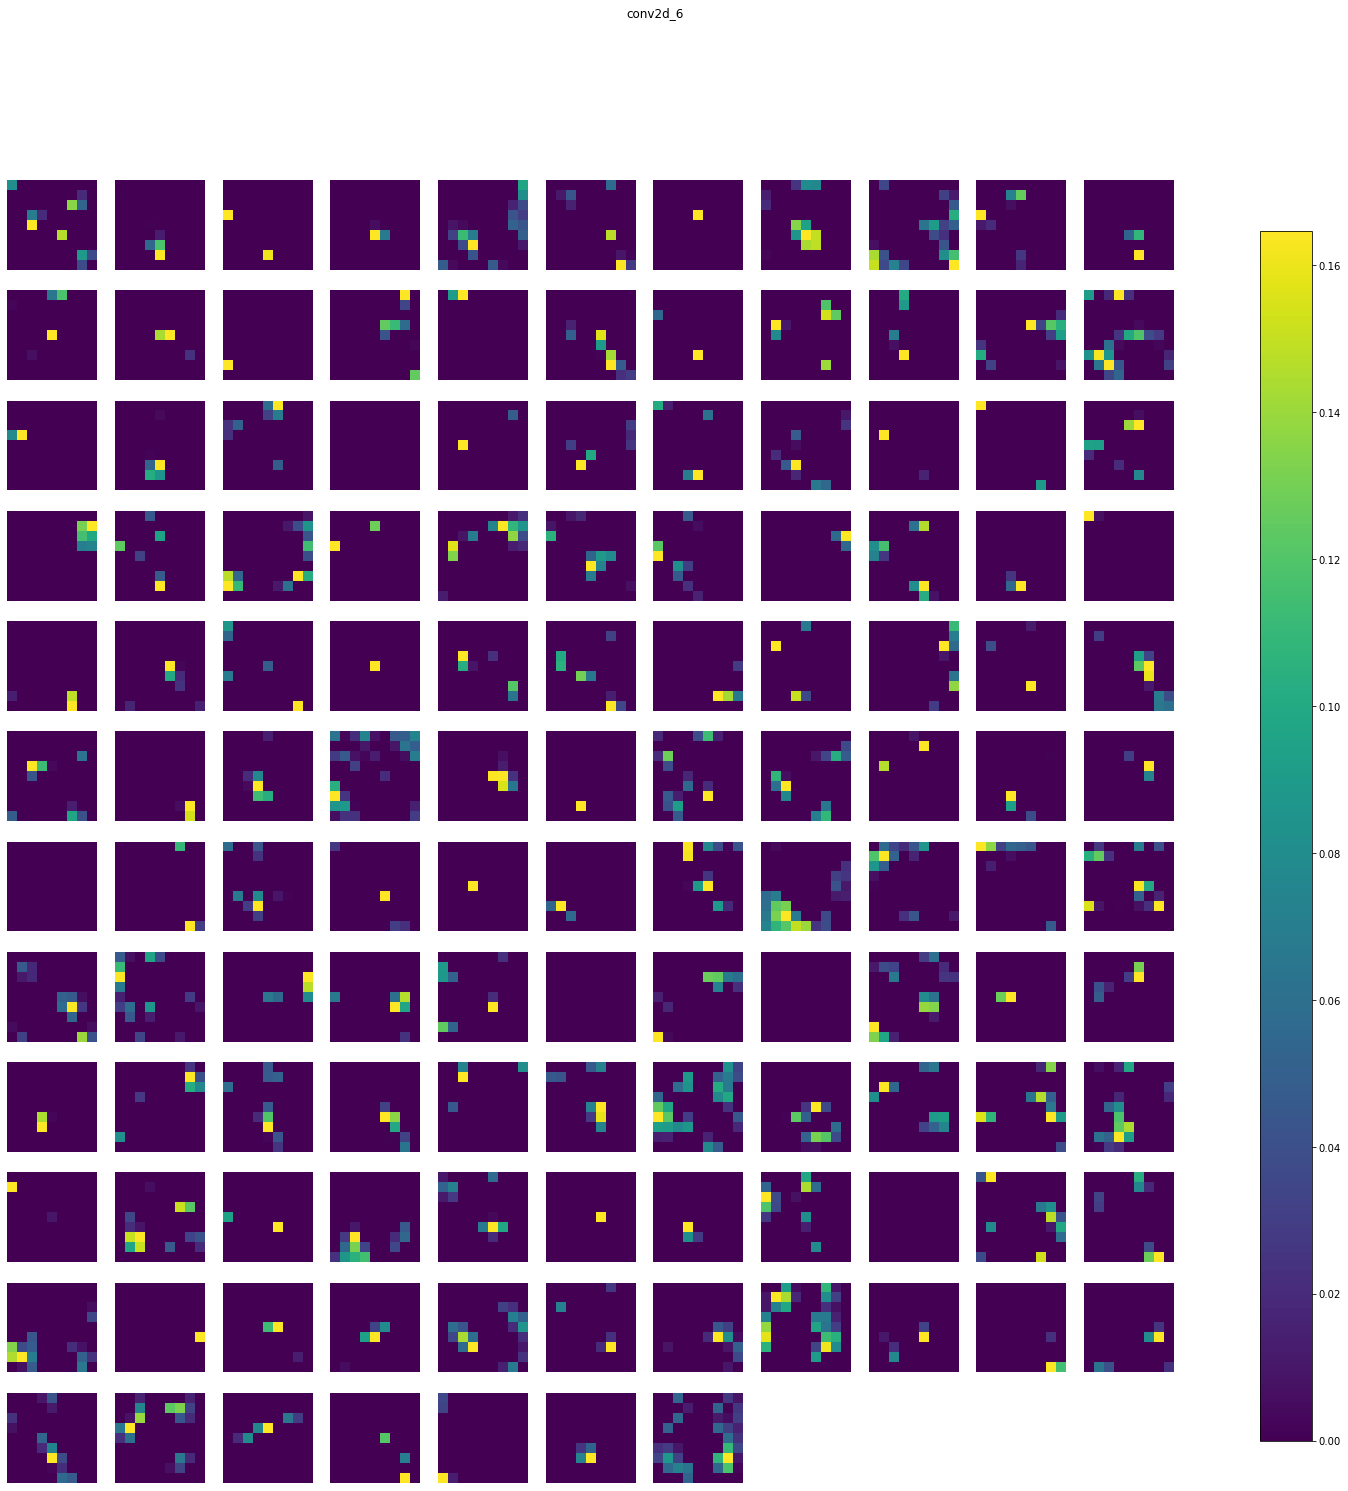

max_pooling2d_6 (1, 4, 4, 128) 


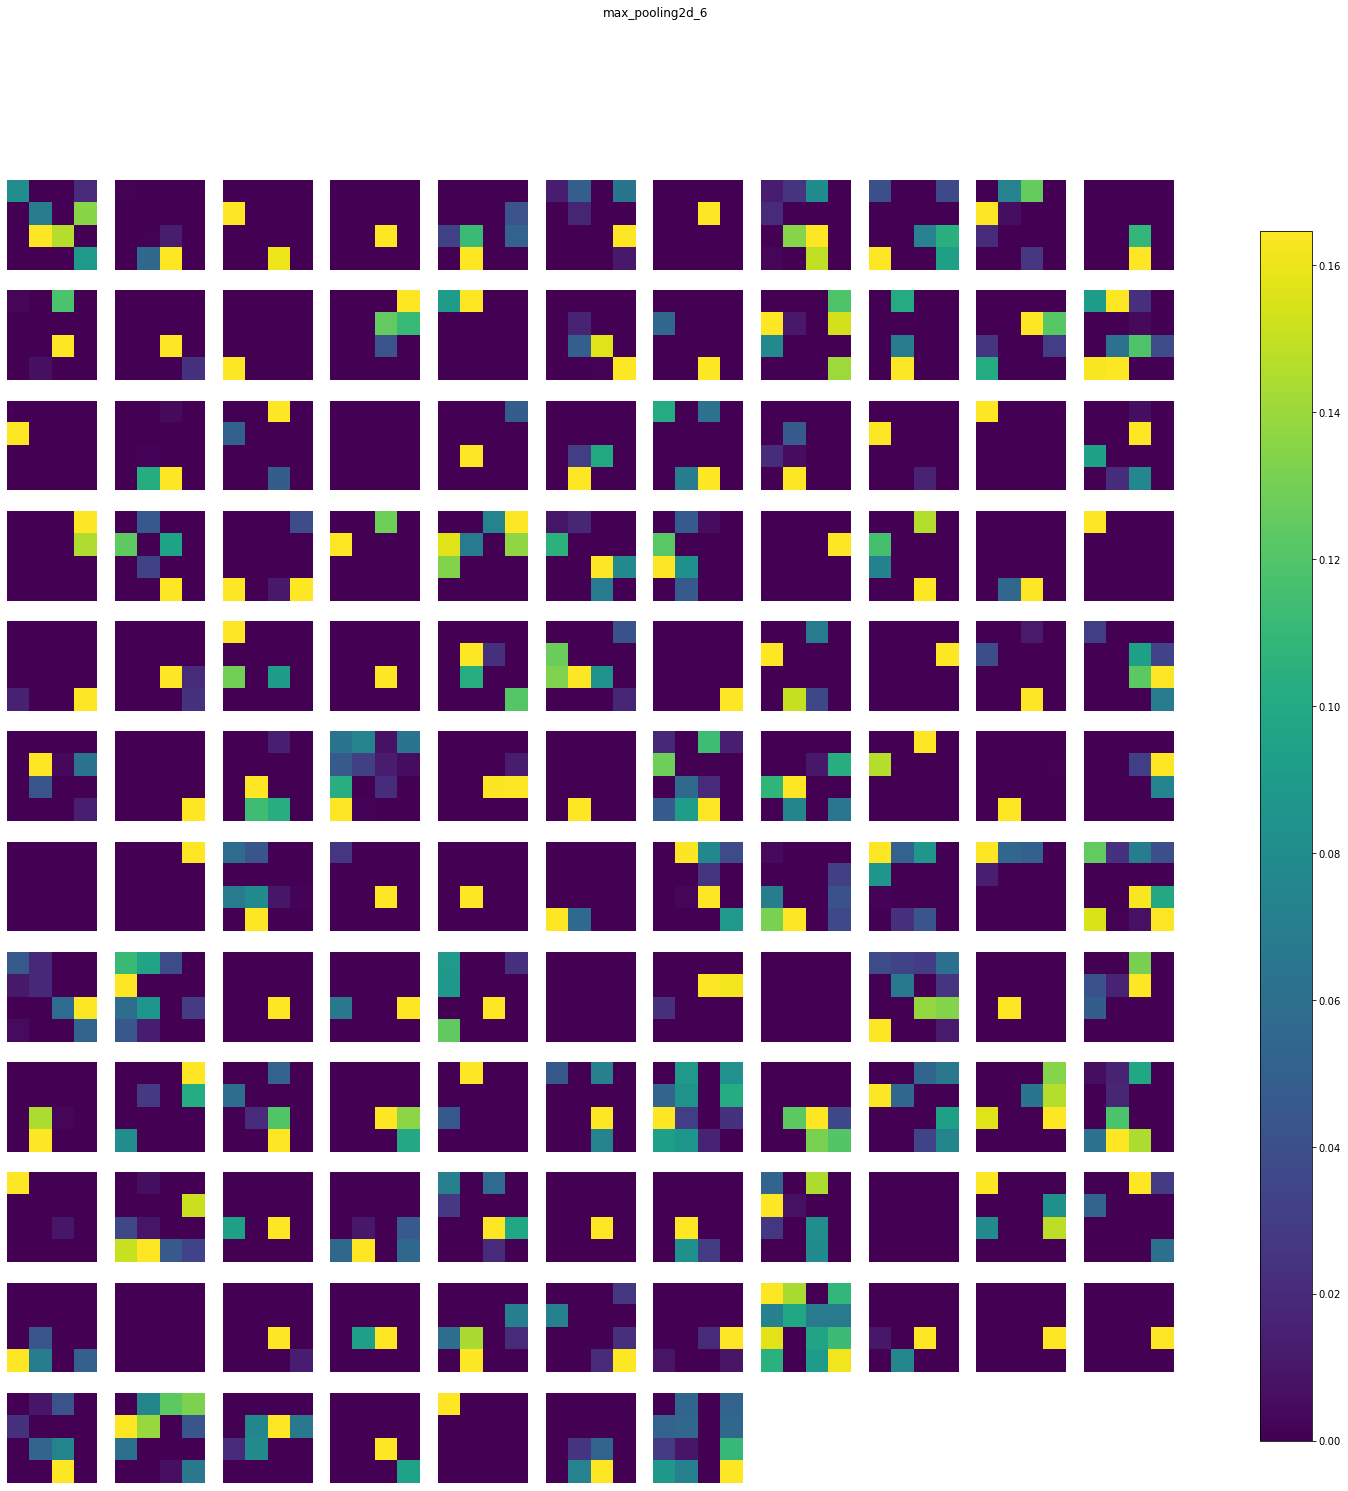

conv2d_7 (1, 2, 2, 256) 


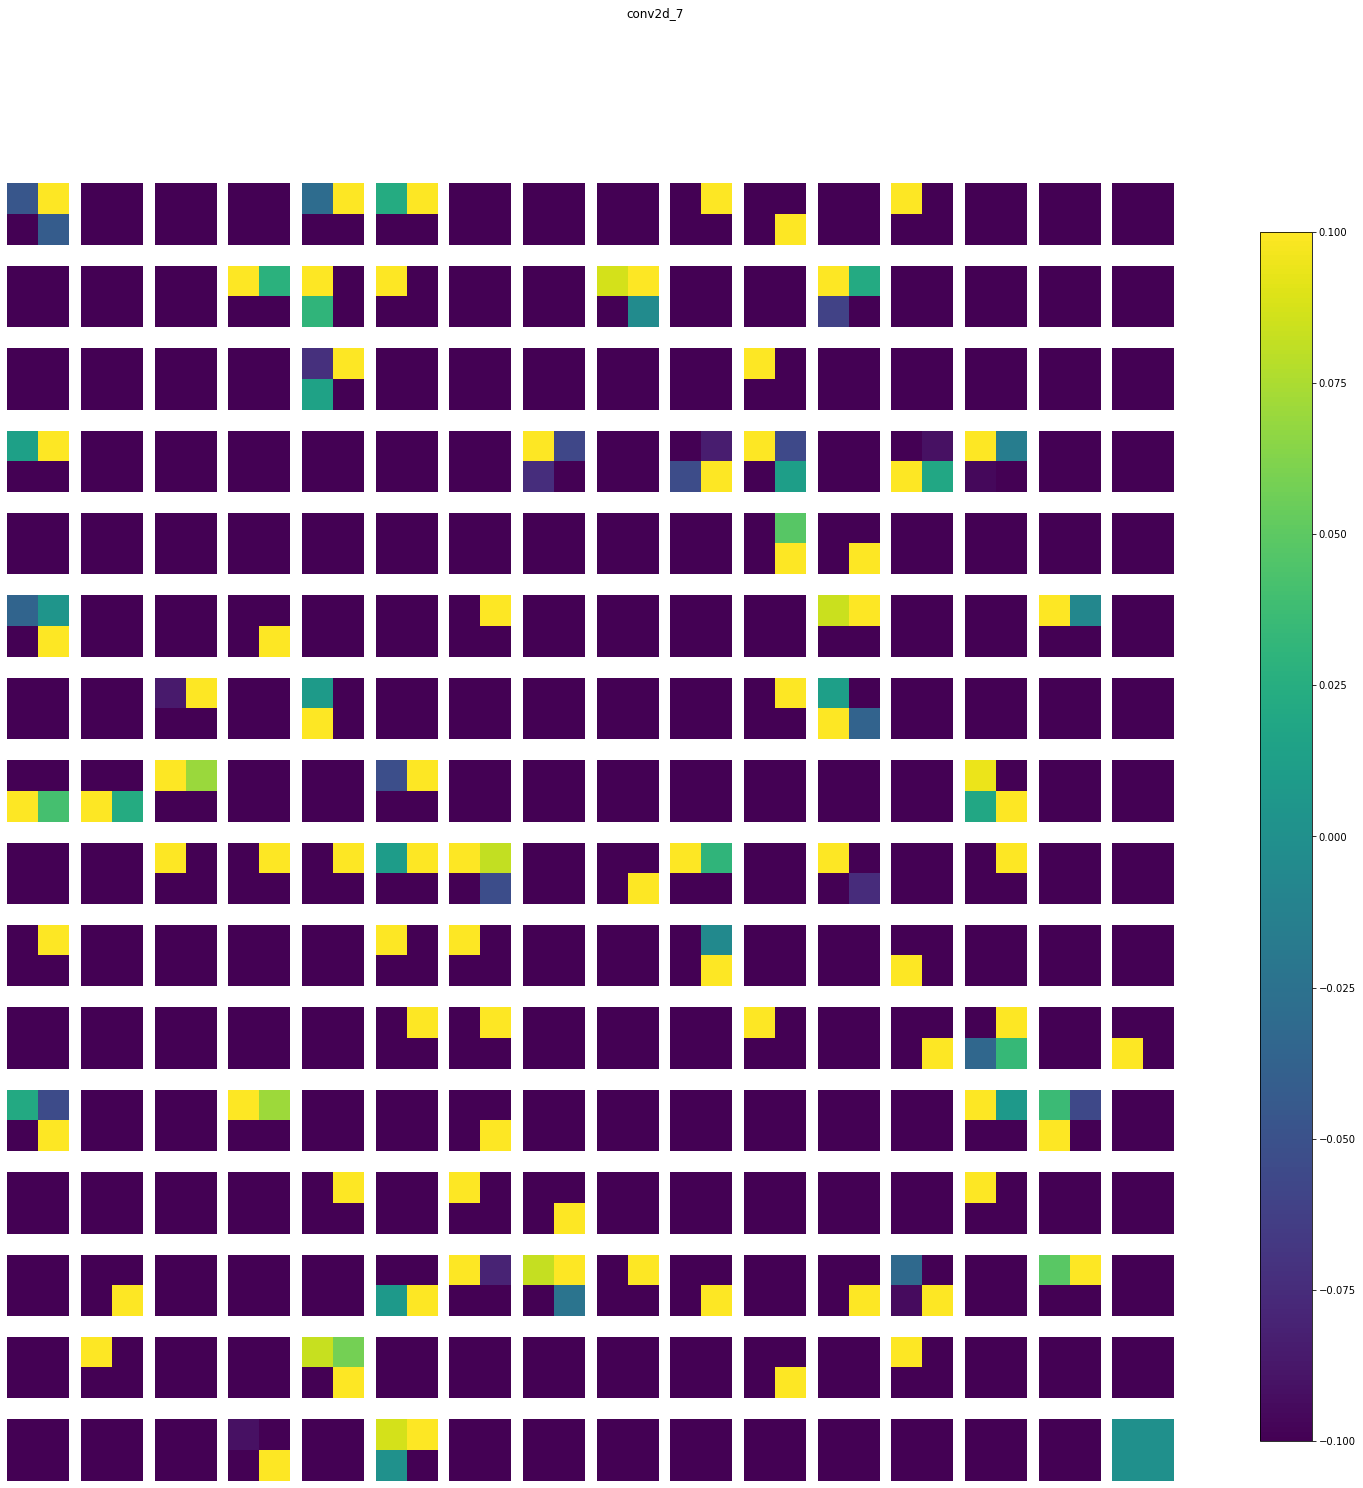

max_pooling2d_7 (1, 1, 1, 256) 


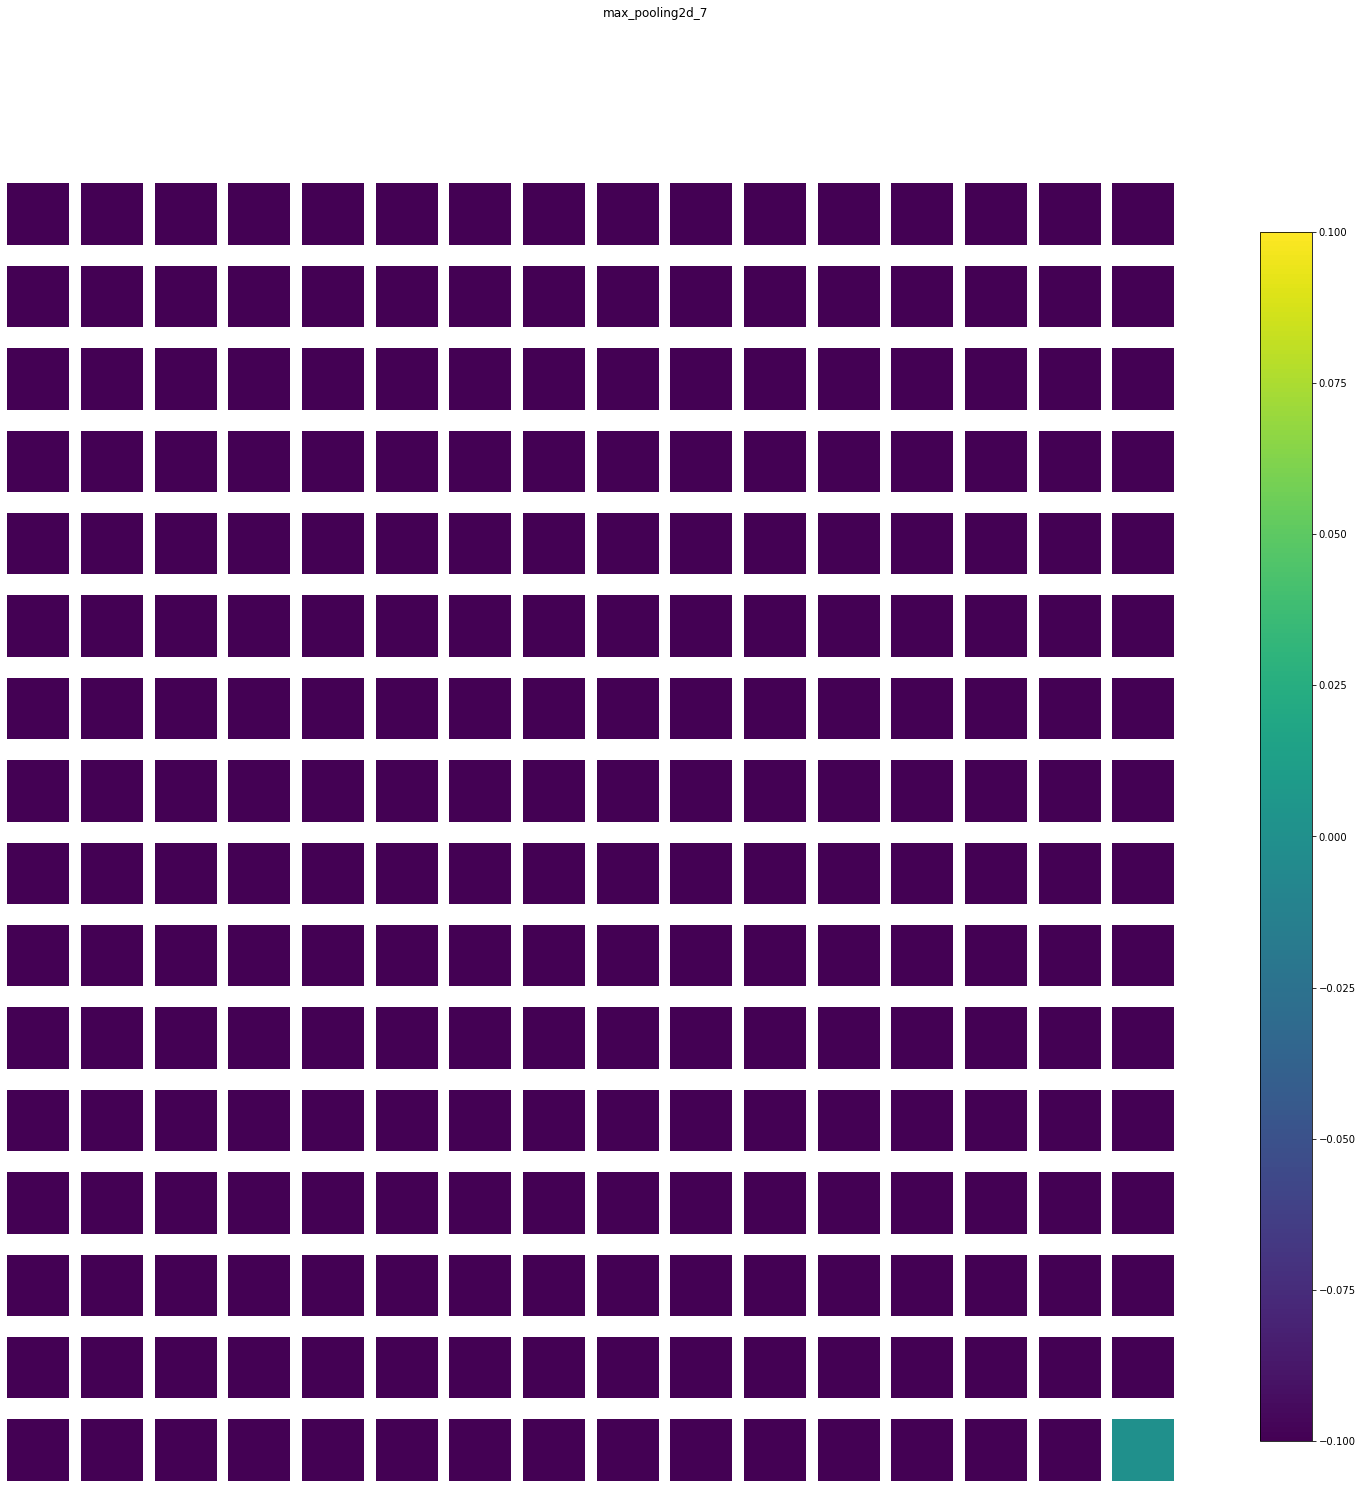

dropout_3 (1, 1, 1, 256) 


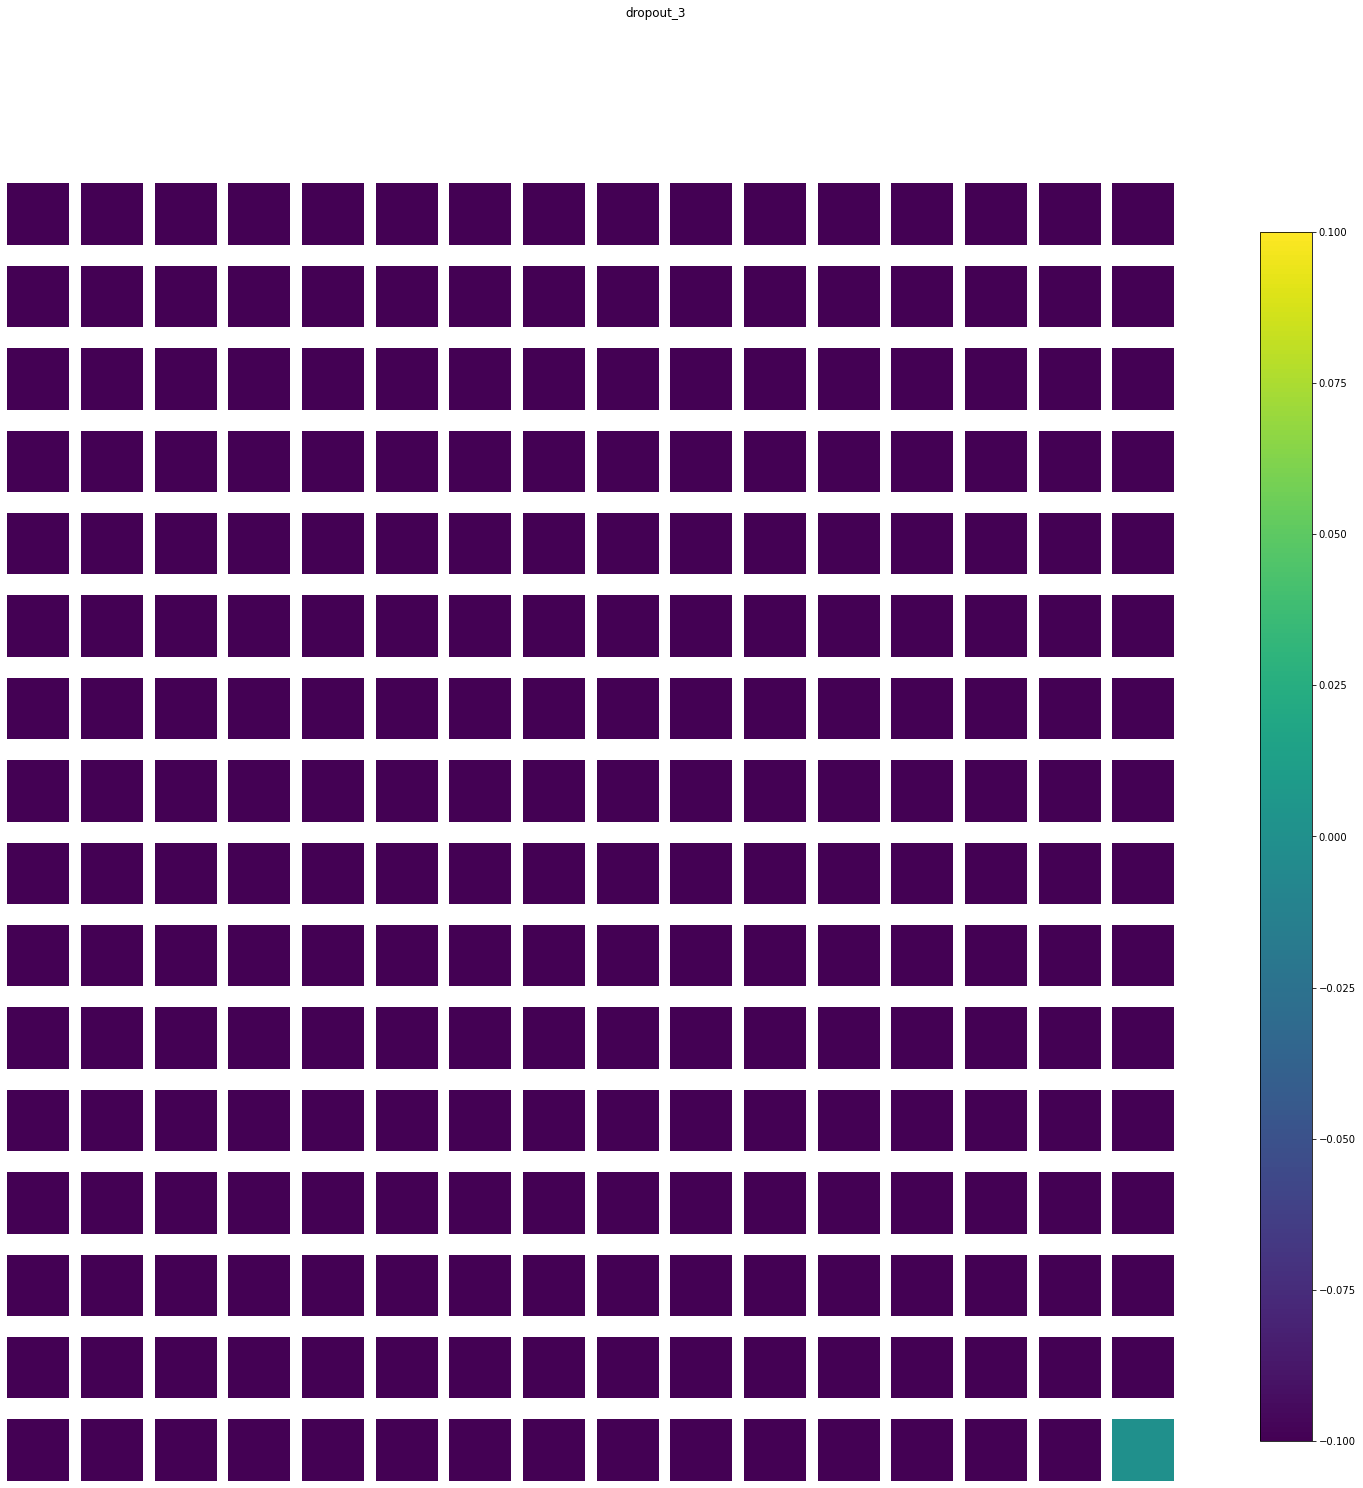

flatten_1 (1, 256) 


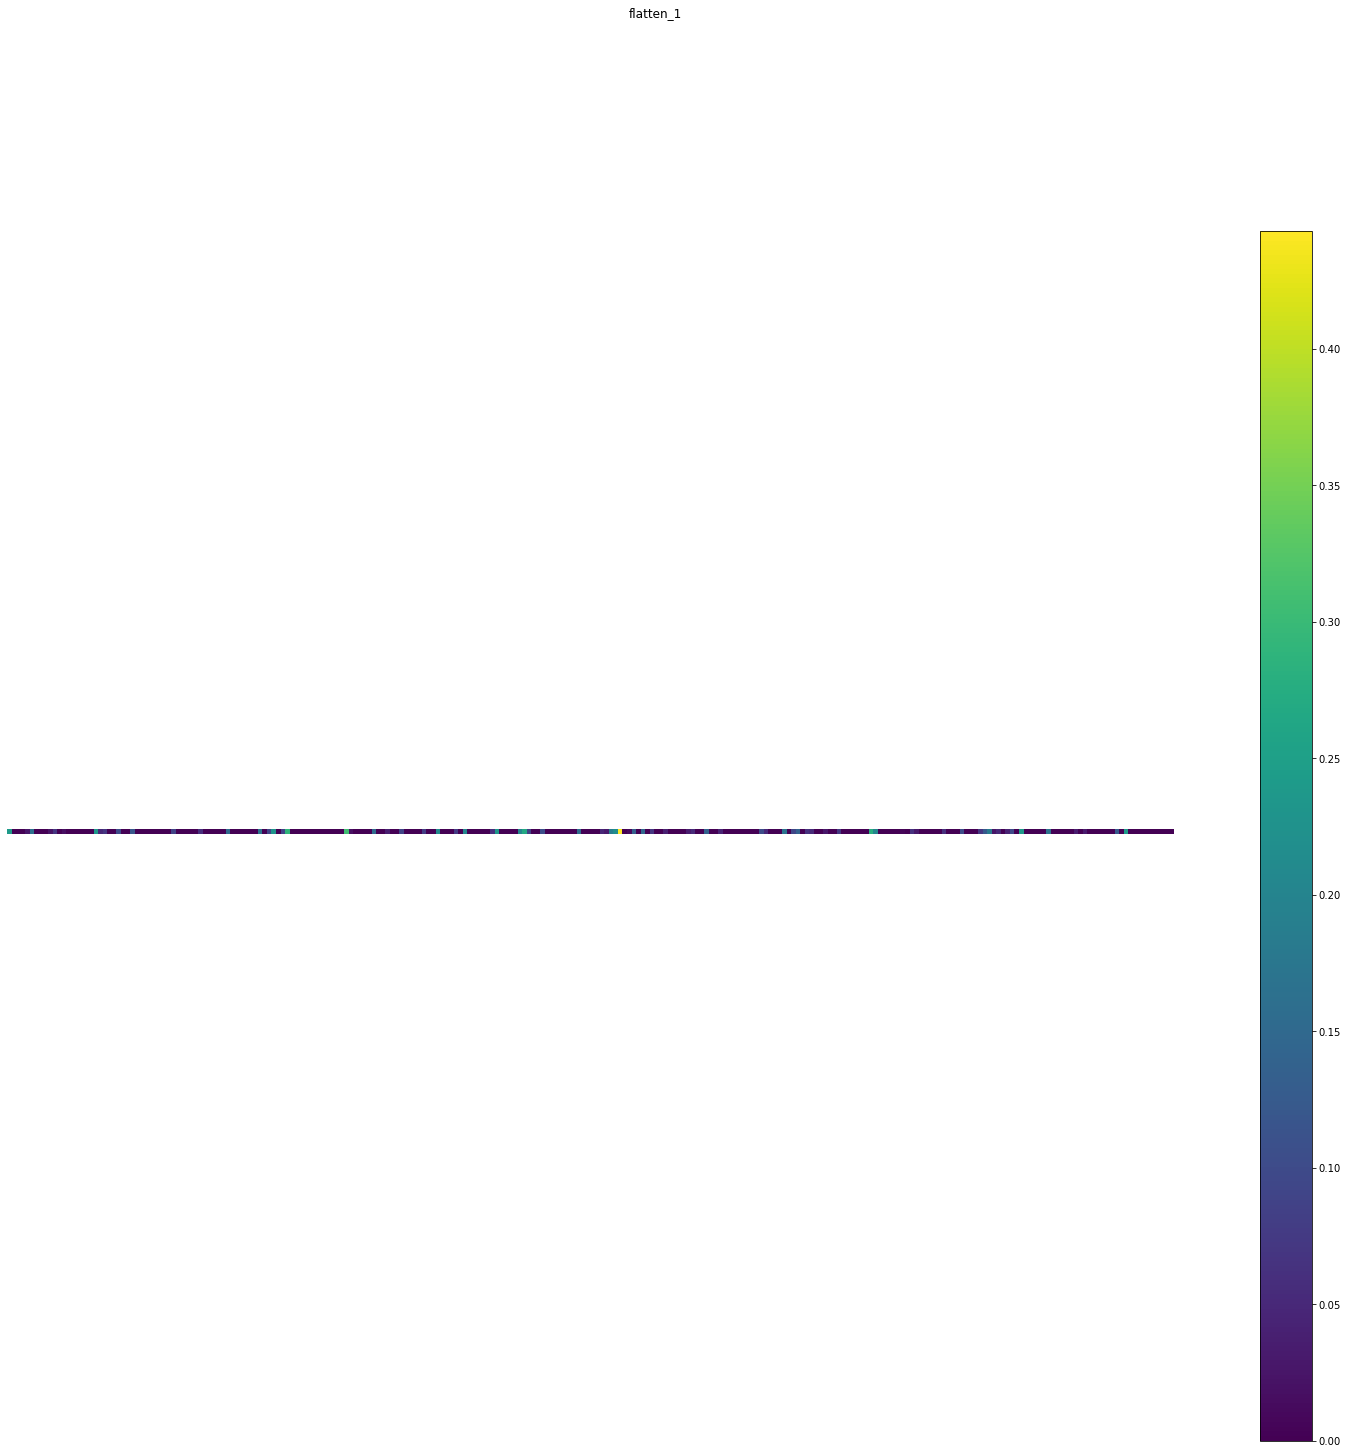

dense_3 (1, 512) 


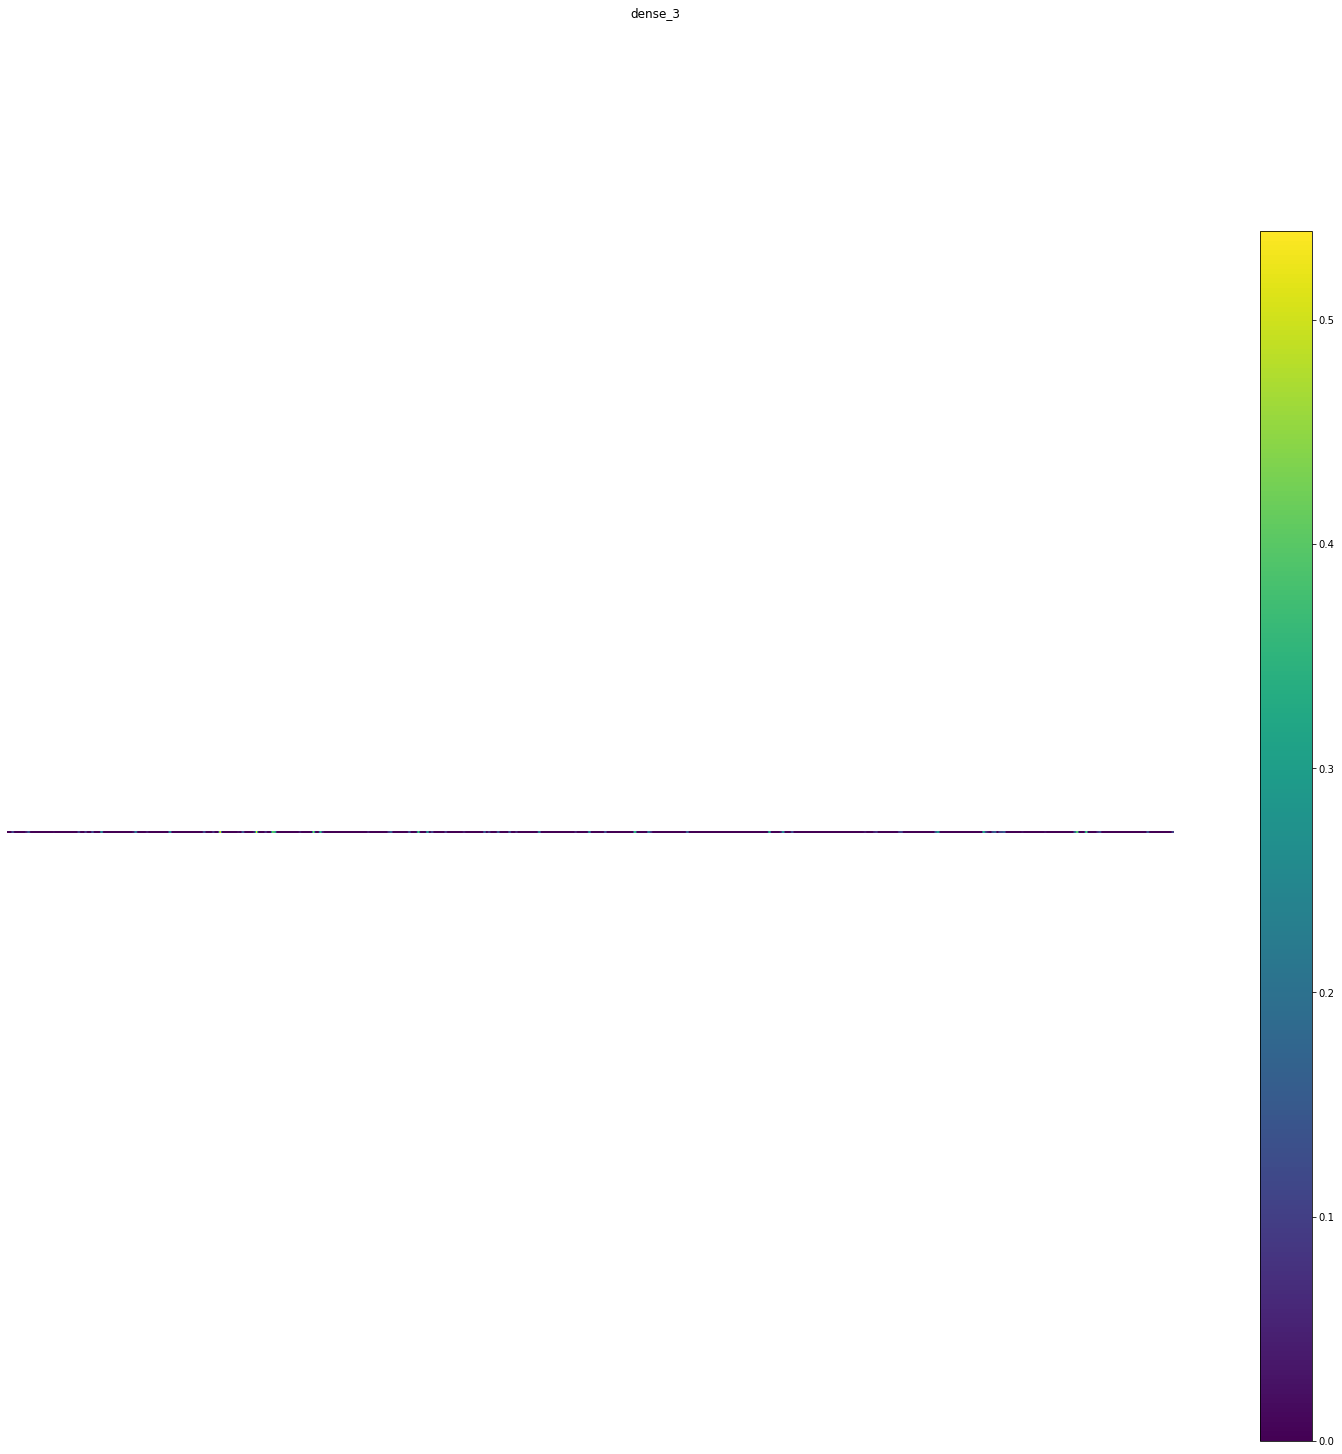

dropout_4 (1, 512) 


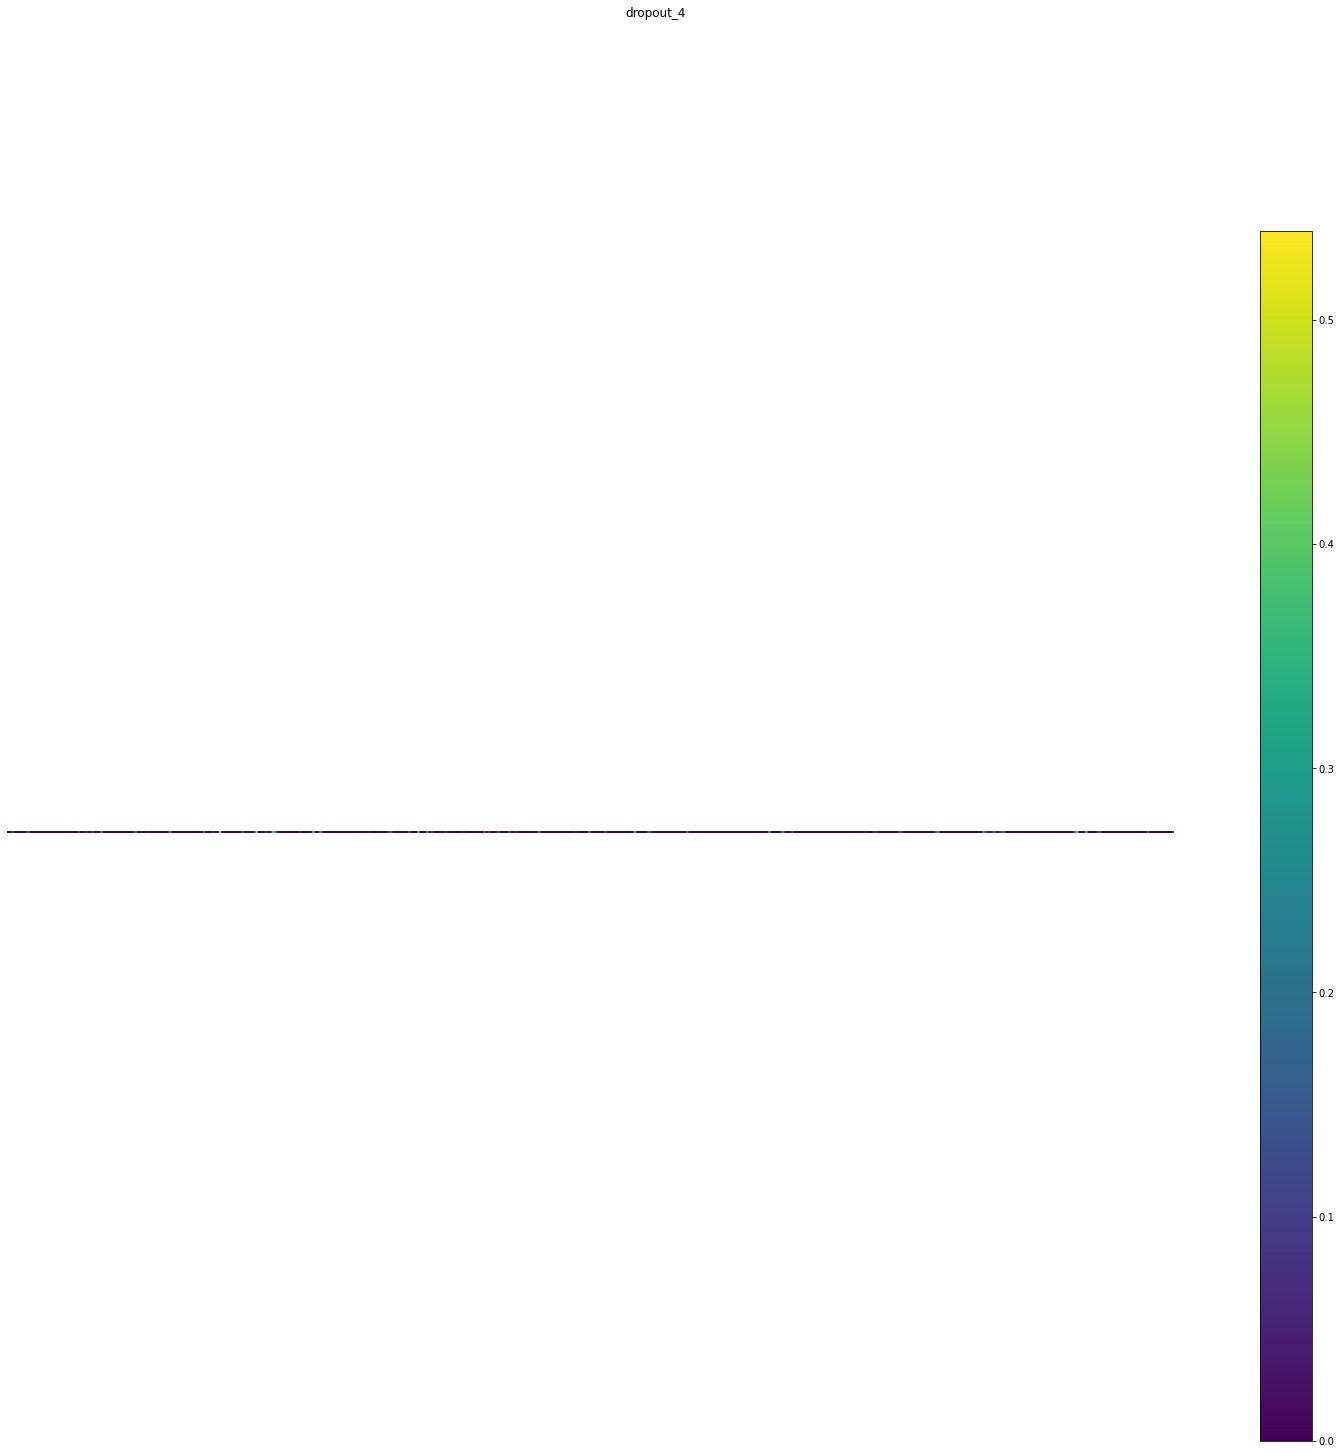

dense_4 (1, 256) 


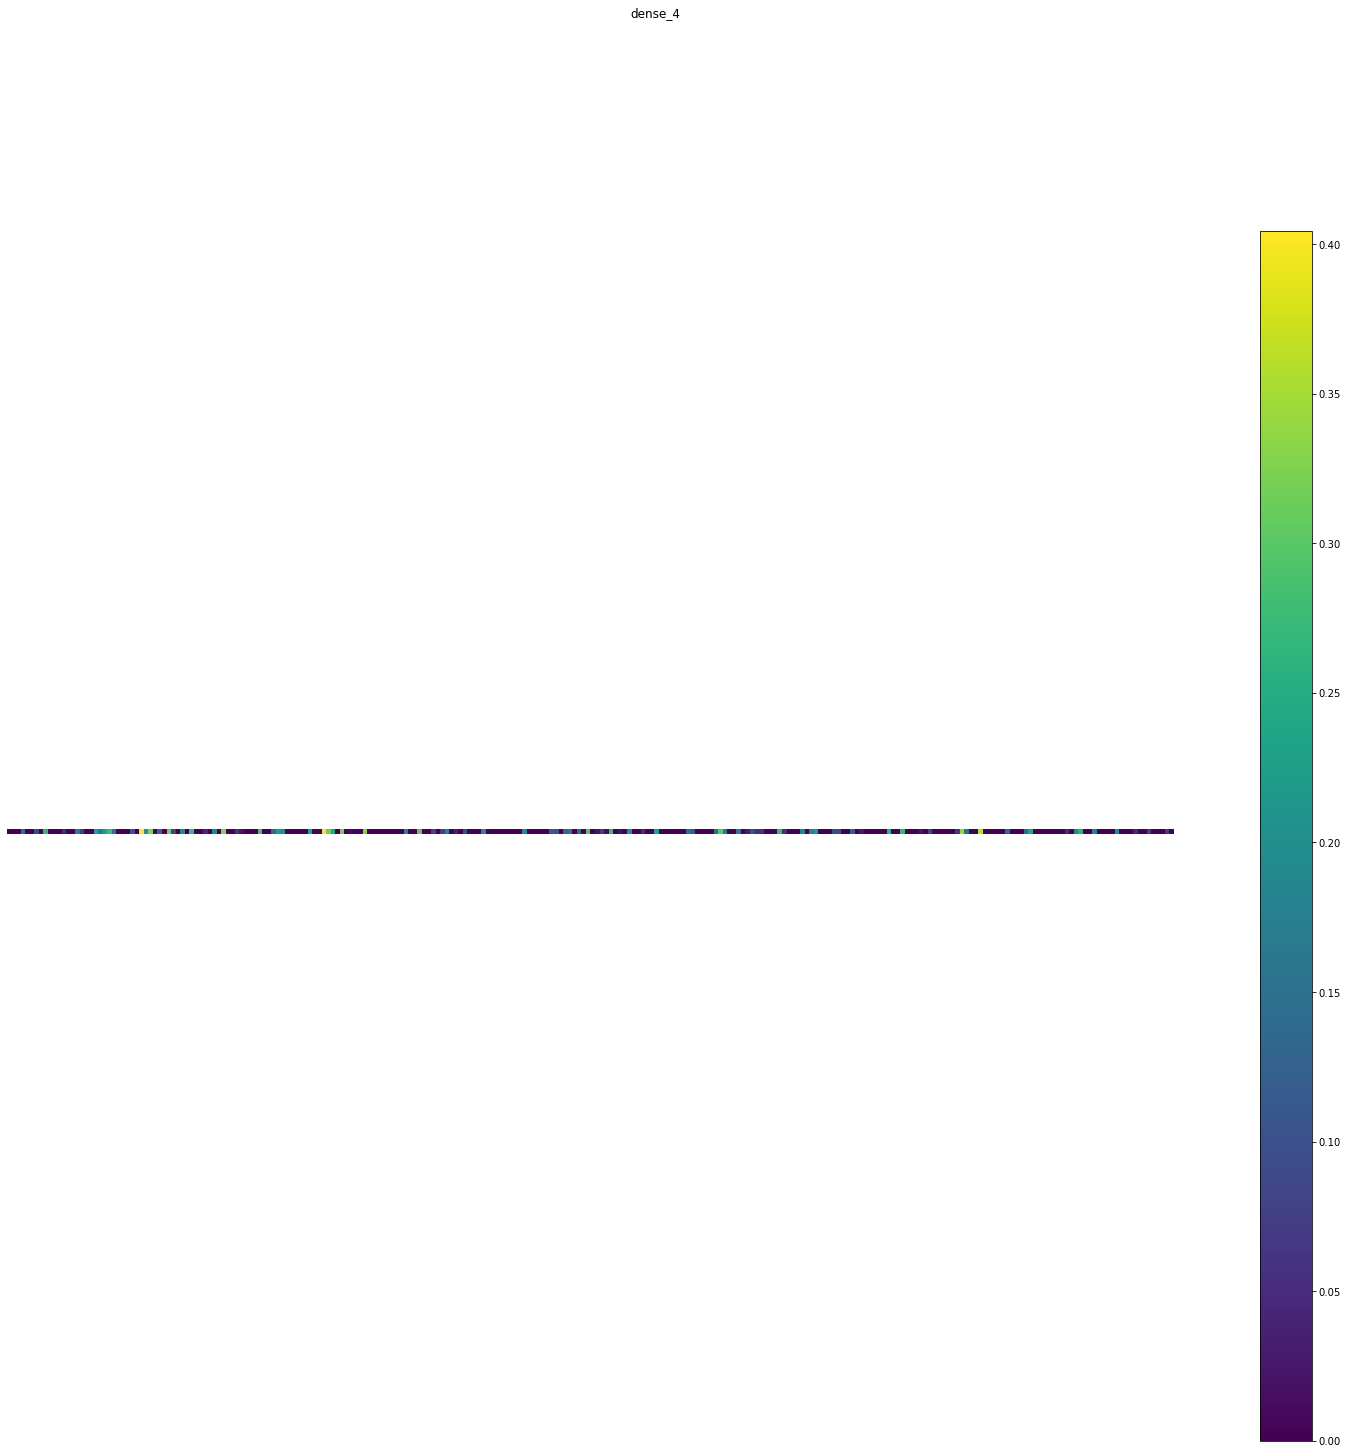

dropout_5 (1, 256) 


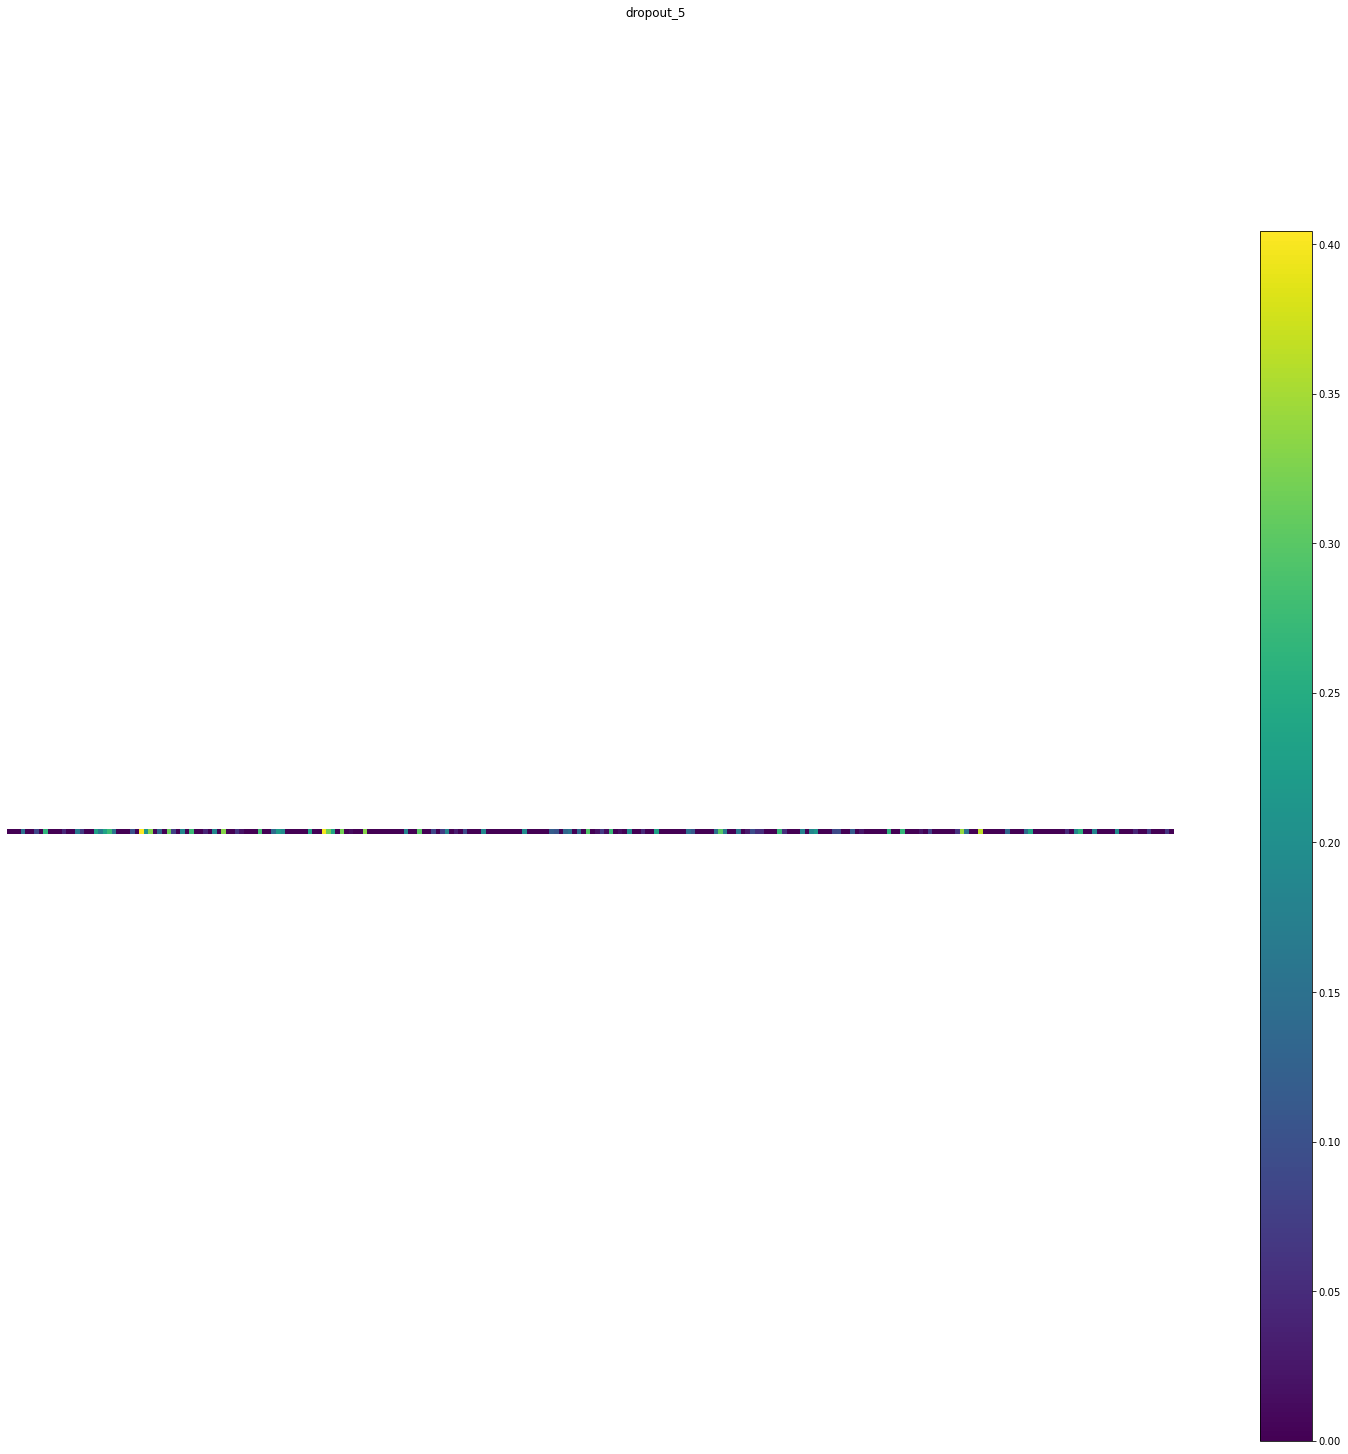

dense_5 (1, 7) 


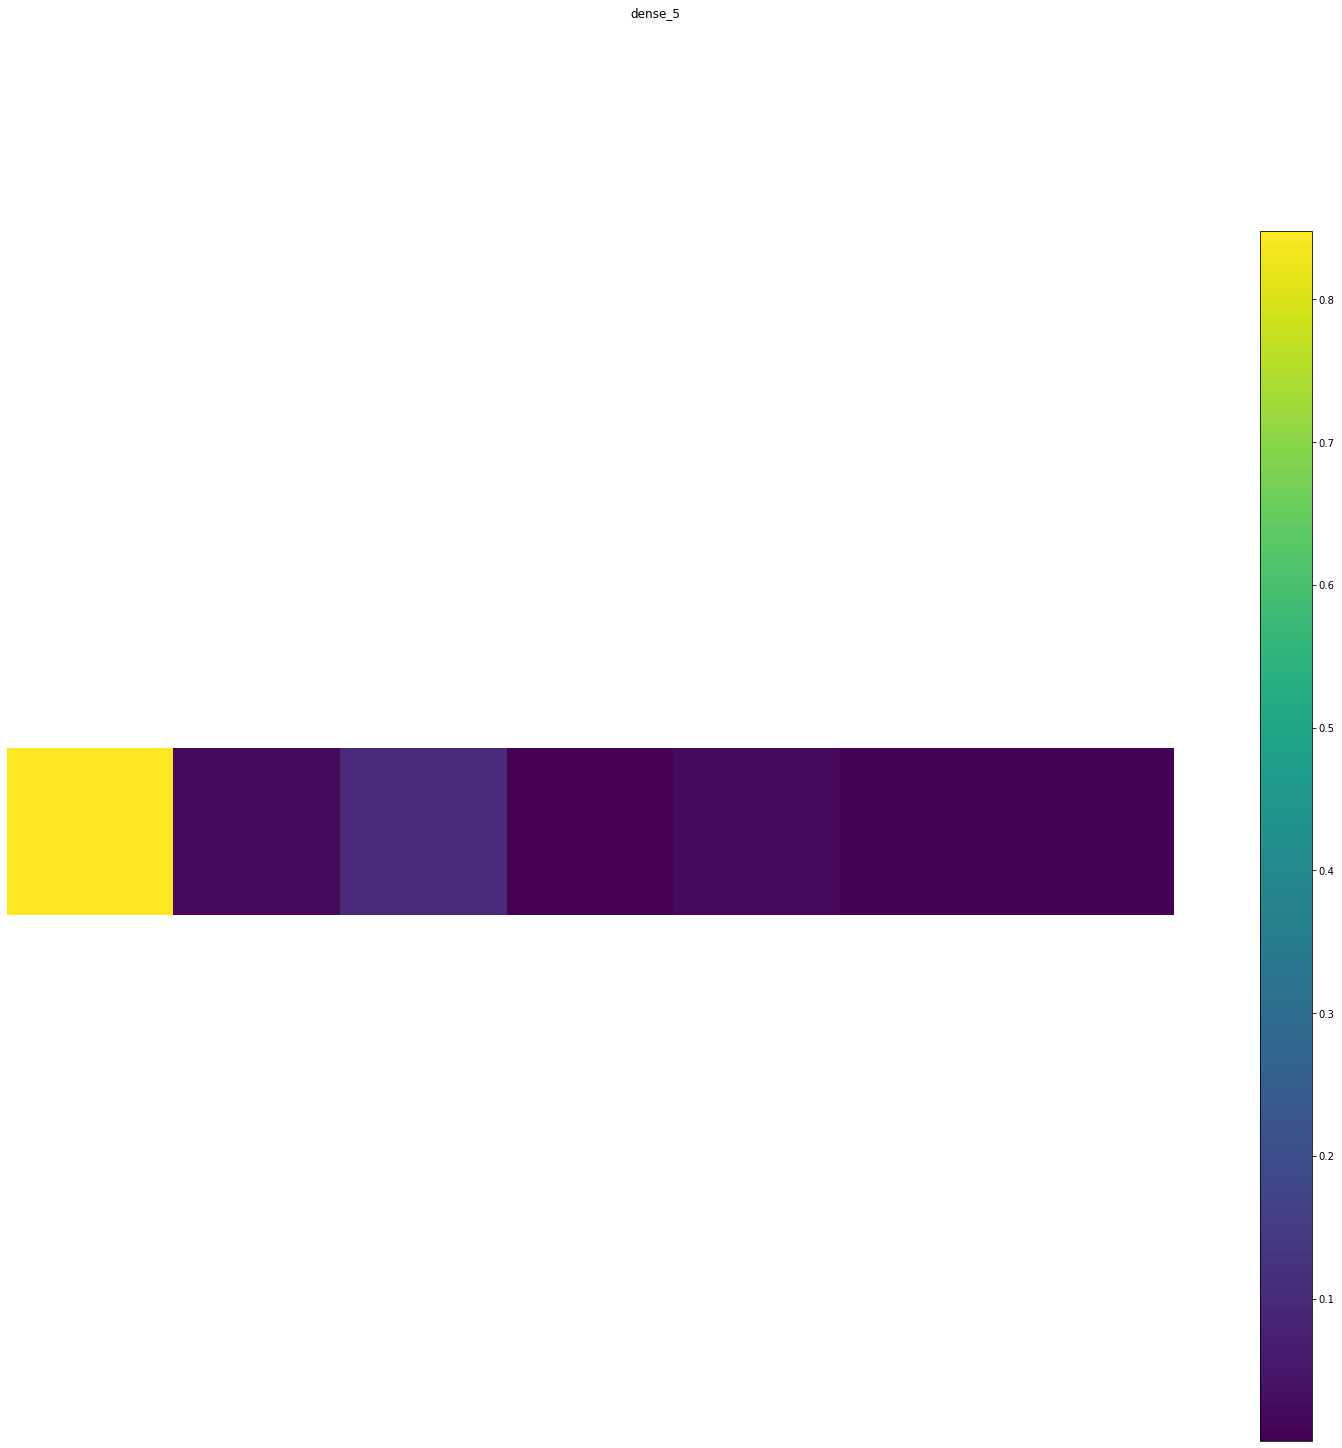

In [53]:
img_idx = np.random.randint(len(X_test))
img = X_test[img_idx]
print(img_idx)
activations = get_activations(loaded_model, expand_img_dims(img))
display_activations(activations, save=False)